# 1. Data Collection

*Basic Steps:*
- Use Stack Exchange API to download the posts from Stack Overflow (SO) with the following tags: [nlp]
- There will be other tags associated with [nlp]. Consider collecting them too.
- Collect other information such as date/time of the posts, no. of views etc.
- Your dataset must include the following information in four different columns: 

  \- title of the posts (1st column)
   
  \- description of the posts (2nd column)
  
  \- tags of the posts (3rd column)
  
  \- At least one Accepted answer (4th column)
  
  \- More accepted answers (5th column) (optional)

- Generate graphs using popular python libraries to visualise the data.

----------------------------------------------------------------------------------------------------

*First I will define some functions to collect posts from stack overflow and use them to create a dataframe for this assignment. These functions include some rules for error handling and rate limiting and so on for dealing with accessing the data from the API. The assignment instructions didn't give any guidance for this, so I had to figure it out from error messages and decide out how to handle it better*.

In [28]:
import requests
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import json
import random
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler("stack_api.log"), logging.StreamHandler()])
logger = logging.getLogger()

def fetch_SO_posts(tag, page_size=100, max_pages=5, max_retries=3, backoff_factor=2):
    """
    Fetch posts from Stack Overflow with a specific tag using Stack Exchange API
    with exponential backoff for error handling
    """
    all_posts = []
    has_more = True
    page = 1
    
    base_url = "https://api.stackexchange.com/2.3/questions"
    
    while has_more and page <= max_pages:
        params = {
            'pagesize': page_size,
            'page': page,
            'order': 'desc',
#            'sort': 'activity',
            'sort': 'votes',  # Sorting by votes often returns more answered questions
            'tagged': tag,
            'site': 'stackoverflow',
            'filter': '!-*jbN-o8P3E5', # This filter includes question bodies and answers
            'answered': 'true'  # Only get questions that have at least one answer
        }

        retry_count = 0
        success = False
        
        while not success and retry_count < max_retries:
            try:
                logger.info(f"Fetching page {page} for tag [{tag}]...")
                response = requests.get(base_url, params=params, timeout=30)
                
                # Check if response is valid
                if response.status_code != 200:
                    logger.warning(f"Error status code: {response.status_code}")
                    if response.status_code == 400:
                        logger.error(f"Bad request. Check API parameters. Response: {response.text}")
                        return all_posts
                    elif response.status_code == 429:
                        # Rate limit exceeded
                        logger.warning("Rate limit exceeded, backing off...")
                        wait_time = (backoff_factor ** retry_count) * 30
                        logger.info(f"Waiting for {wait_time} seconds")
                        time.sleep(wait_time)
                        retry_count += 1
                        continue
                    elif response.status_code == 403:
                        logger.error("Forbidden. API key may be required.")
                        return all_posts
                    else:
                        logger.warning(f"HTTP error: {response.status_code}")
                        wait_time = (backoff_factor ** retry_count) * 10
                        logger.info(f"Waiting for {wait_time} seconds")
                        time.sleep(wait_time)
                        retry_count += 1
                        continue
                
                # Try to parse JSON
                try:
                    data = response.json()
                    success = True
                except json.JSONDecodeError as e:
                    logger.warning(f"JSON decode error: {e}")
                    # Print the response content for debugging
                    logger.warning(f"Response content: {response.text[:200]}...")
                    wait_time = (backoff_factor ** retry_count) * 10
                    logger.info(f"Waiting for {wait_time} seconds")
                    time.sleep(wait_time)
                    retry_count += 1
                    continue
                
                # Check if we got data
                if 'items' in data:
                    all_posts.extend(data['items'])
                    
                # Check quota
                if 'quota_remaining' in data:
                    quota_remaining = data['quota_remaining']
                    logger.info(f"API quota remaining: {quota_remaining}")
                    if quota_remaining < 10:
                        logger.warning("Low on quota, waiting longer...")
                        time.sleep(60)  # Wait longer when quota is low
                
                has_more = data.get('has_more', False)
                
                # Add a delay between requests
                delay = random.uniform(1.5, 3.0)
                logger.info(f"Sleeping for {delay:.2f} seconds")
                time.sleep(delay)
                
                page += 1
                break  # Exit retry loop on success
                
            except requests.exceptions.RequestException as e:
                logger.error(f"Request exception: {e}")
                wait_time = (backoff_factor ** retry_count) * 10
                logger.info(f"Waiting for {wait_time} seconds")
                time.sleep(wait_time)
                retry_count += 1
        
        if not success:
            logger.error(f"Failed to fetch data after {max_retries} retries")
            break
    
    logger.info(f"Total posts fetched for tag [{tag}]: {len(all_posts)}")
    return all_posts

def fetch_multiple_tags(tags, page_size=100, max_pages_per_tag=5):
    """
    Fetch posts for multiple tags and combine the results, removing duplicates
    with rate limiting between tags
    """
    all_posts = []
    seen_question_ids = set()
    
    for i, tag in enumerate(tags):
        # Add a longer delay between different tags
        if i > 0:
            wait_time = random.uniform(5, 10)
            logger.info(f"Waiting {wait_time:.2f} seconds before fetching next tag")
            time.sleep(wait_time)
        
        try:
            posts = fetch_SO_posts(tag, page_size, max_pages_per_tag)
            
            # Add only new questions (avoid duplicates)
            for post in posts:
                if 'question_id' in post and post['question_id'] not in seen_question_ids:
                    all_posts.append(post)
                    seen_question_ids.add(post['question_id'])
        except Exception as e:
            logger.error(f"Error fetching posts for tag {tag}: {e}")
            continue
    
    logger.info(f"Total unique posts fetched across all tags: {len(all_posts)}")
    
    # Save the raw data to a backup file
    try:
        with open('raw_posts_backup.json', 'w') as f:
            json.dump(all_posts, f)
        logger.info("Saved raw posts to backup file")
    except Exception as e:
        logger.error(f"Error saving backup file: {e}")
    
    return all_posts

def prepare_dataset(posts):
    """
    Process the fetched posts into a structured DataFrame
    """
    if not posts:
        logger.error("No posts to process")
        return pd.DataFrame()
    
    dataset = []
    
    for post in posts:
        try:
            # Initialize data for this post
            post_data = {
                'title': post.get('title', ''),
                'description': post.get('body_markdown', post.get('body', '')),  # Try markdown first, then HTML
                'tags': post.get('tags', []),
                'accepted_answer': '',
                'other_answers': [],
                'creation_date': datetime.fromtimestamp(post.get('creation_date', 0)),
                'view_count': post.get('view_count', 0),
                'score': post.get('score', 0),
                'answer_count': post.get('answer_count', 0),
                'is_answered': post.get('is_answered', False),
                'link': post.get('link', '')
            }
            
            # Process answers if they exist
            if 'answers' in post and isinstance(post['answers'], list):
                accepted_answer = None
                other_answers = []
                
                for answer in post['answers']:
                    answer_body = answer.get('body_markdown', answer.get('body', ''))
                    
                    if answer.get('is_accepted', False):
                        accepted_answer = answer_body
                    else:
                        other_answers.append({
                            'body': answer_body,
                            'score': answer.get('score', 0)
                        })
                
                # Sort other answers by score
                other_answers.sort(key=lambda x: x['score'], reverse=True)
                
                # Set the accepted answer
                post_data['accepted_answer'] = accepted_answer if accepted_answer else ''
                
                # Get top scored non-accepted answers (for the optional 5th column)
                post_data['other_answers'] = [a['body'] for a in other_answers]
                # If we want just the top answer for the 5th column
                post_data['top_other_answer'] = other_answers[0]['body'] if other_answers else ''
            
            dataset.append(post_data)
        except Exception as e:
            logger.error(f"Error processing post: {e}")
            continue
    
    if not dataset:
        logger.error("No valid posts data after processing")
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(dataset)
    
    # Convert tags list to comma-separated string for better readability
    df['tags_str'] = df['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
    
    return df

Having defined those functions, the code to call them to begin the dataset download and prepare the dataframe is actually very simple - only a few lines of function calls. It may take some time to run, however. And the logger will list every step of the process as the data is downloaded.

In [30]:
# List of NLP-related tags to collect

# (per assignment instruction: "There will be other tags associated with [nlp]. Consider collecting them too")
nlp_related_tags = [
        'nlp',
        'natural-language-processing',
        'text-mining',
        'word-embeddings',
        'tokenization',
        'named-entity-recognition',
        'text-classification',
        'sentiment-analysis',
        'bert',
        'transformers',
        'spacy',
        'gensim',
        'word2vec',
        'huggingface',
        'language-model',
        'text-processing',
        'nltk'
]
    
# You can either fetch posts for a single tag
# posts = fetch_SO_posts('nlp', page_size=100, max_pages=5)    
# Or fetch posts for multiple tags (better for larger dataset)
posts = fetch_multiple_tags(nlp_related_tags, page_size=100, max_pages_per_tag=20)
    
# Process into DataFrame using the prepare_dataset function
df = prepare_dataset(posts)
    
# Save the raw data
df.to_csv('nlp_stackoverflow_raw_posts.csv', index=False)

2025-04-16 21:26:23,882 - INFO - Fetching page 1 for tag [nlp]...
2025-04-16 21:26:25,131 - INFO - API quota remaining: 299
2025-04-16 21:26:25,132 - INFO - Sleeping for 2.58 seconds
2025-04-16 21:26:27,709 - INFO - Total posts fetched for tag [nlp]: 98
2025-04-16 21:26:27,709 - INFO - Waiting 8.79 seconds before fetching next tag
2025-04-16 21:26:36,597 - INFO - Fetching page 1 for tag [natural-language-processing]...
2025-04-16 21:26:37,235 - INFO - API quota remaining: 298
2025-04-16 21:26:37,238 - INFO - Sleeping for 1.68 seconds
2025-04-16 21:26:38,922 - INFO - Total posts fetched for tag [natural-language-processing]: 98
2025-04-16 21:26:38,922 - INFO - Waiting 9.80 seconds before fetching next tag
2025-04-16 21:26:48,746 - INFO - Fetching page 1 for tag [text-mining]...
2025-04-16 21:26:49,473 - INFO - API quota remaining: 297
2025-04-16 21:26:49,475 - INFO - Sleeping for 2.91 seconds
2025-04-16 21:26:52,382 - INFO - Fetching page 2 for tag [text-mining]...
2025-04-16 21:26:53,0

----------------------------------------------------------------------------------------------------

# 2. Pre-processing

Perform some pre-processing on each column of the dataset. For example, remove the punctuation marks, special symbols, convert to lower case, remove screenshots from the posts and answers, tokenization etc.

In the next block I will also define a function to *pre-process* the dataset in several of the ways described:

In [38]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd

# Download necessary NLTK resources (this only needs to be run once)
#def download_nltk_resources():
#    try:
#        nltk.data.find('corpora/stopwords')
#        nltk.data.find('tokenizers/punkt')
#    except LookupError:
#        nltk.download('stopwords')
#        nltk.download('punkt')


# This is the preprocessing function:
def preprocess_data(df):
    """
    Preprocess the dataset to clean text fields and prepare for visualization
    """
    print("Starting data preprocessing...")
    
    # Create a copy to avoid modifying the original
    processed_df = df.copy()
    
    # Function to clean HTML and text
    def clean_text(text):
        if not isinstance(text, str) or pd.isna(text):
            return ""
        
        # Remove HTML tags
        soup = BeautifulSoup(text, "html.parser")
        clean_text = soup.get_text(separator=" ")
        
        # Remove code blocks (often surrounded by backticks or <code> tags)
        clean_text = re.sub(r'```.*?```', '', clean_text, flags=re.DOTALL)
        clean_text = re.sub(r'`.*?`', '', clean_text)
        
        # Convert to lowercase
        clean_text = clean_text.lower()
        
        # Remove special characters and numbers
        clean_text = re.sub(r'[^\w\s]', ' ', clean_text)
        clean_text = re.sub(r'\d+', ' ', clean_text)
        
        # Remove extra whitespace
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        
        return clean_text
    
    # Apply text cleaning to title, description, and answers
    text_columns = ['title', 'description', 'accepted_answer', 'top_other_answer']
    for col in text_columns:
        if col in processed_df.columns:
            print(f"Cleaning {col} column...")
            processed_df[f'clean_{col}'] = processed_df[col].apply(clean_text)
    
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    
    def tokenize_and_remove_stopwords(text):
        if not isinstance(text, str) or pd.isna(text) or text == "":
            return []
        
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words and len(word) > 2]
        return filtered_tokens
    
    # Apply tokenization to cleaned text columns
    for col in text_columns:
        clean_col = f'clean_{col}'
        if clean_col in processed_df.columns:
            print(f"Tokenizing {clean_col} column...")
            processed_df[f'tokens_{col}'] = processed_df[clean_col].apply(tokenize_and_remove_stopwords)
    
    # Create combined tokens for overall word frequency analysis
    processed_df['all_tokens'] = processed_df.apply(
        lambda row: (
            row.get('tokens_title', []) + 
            row.get('tokens_description', []) + 
            row.get('tokens_accepted_answer', [])
        ), 
        axis=1
    )
    
    # Calculate text lengths for additional analysis
    for col in text_columns:
        if col in processed_df.columns:
            processed_df[f'{col}_length'] = processed_df[col].apply(
                lambda x: len(x.split()) if isinstance(x, str) else 0
            )
    
    # Calculate metrics
    if 'accepted_answer' in processed_df.columns:
        processed_df['has_accepted_answer'] = processed_df['accepted_answer'].apply(
            lambda x: 0 if pd.isna(x) or x == "" else 1
        )
    
    print("Preprocessing complete.")
    return processed_df

Now I will make a very straightforward call to pre-process the dataframe from earlier (step 1), using the above function. The dataframe with required columns will be printed to csv file 'nlp_posts_required_columns.csv'

In [42]:
# Preprocess the data
processed_df = preprocess_data(df)

# Save the required columns in the specified order
required_columns = ['title', 'description', 'tags_str', 'accepted_answer', 'top_other_answer']
processed_df[required_columns].to_csv('nlp_posts_required_columns.csv', index=False)
    
print(f"Data saved to CSV files. Total posts: {len(df)}")

# Print sample of the collected processed dataframe:
print("\nSample of collected data:")
print(processed_df[['title', 'creation_date', 'view_count', 'tags_str']].head())

# Print sample of a few lines of data from collected datafile:
print("\nSample of collected data:\n")
with open('nlp_posts_required_columns.csv', "r") as file_read:
    for i in range(0,5):
        reader = file_read.readline()
        print(reader)


Starting data preprocessing...
Cleaning title column...


C:\Users\cnuge\AppData\Local\Temp\ipykernel_18364\3928343919.py:39: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Cleaning description column...
Cleaning accepted_answer column...
Cleaning top_other_answer column...
Tokenizing clean_title column...
Tokenizing clean_description column...
Tokenizing clean_accepted_answer column...
Tokenizing clean_top_other_answer column...
Preprocessing complete.
Data saved to CSV files. Total posts: 20009

Sample of collected data:
                                               title       creation_date  \
0  How does the Google &quot;Did you mean?&quot; ... 2008-11-21 10:04:51   
1  How to compute the similarity between two text... 2012-01-18 02:21:09   
2  googletrans stopped working with error &#39;No... 2018-09-22 19:59:08   
3  What is the difference between lemmatization v... 2009-11-24 11:18:11   
4  How to determine the language of a piece of text? 2016-08-25 19:56:00   

   view_count                                           tags_str  
0      104134  algorithm, machine-learning, nlp, spell-checki...  
1      316447                                        

----------------------------------------------------------------------------------------------------

# 3. Graphical Representation of the Dataset

Provide a visual representation of most frequent terms (often known as Word cloud) used in the titles of the posts. Hint: use WordCloud in python. Do some preprocessing such as removing stop words before generating the word cloud. Note that if you do not carefully pre-process your dataset, the word cloud might not truly represent the important terms in the titles of the Stack Overflow posts.

This function appears long, but it's only here to run a long series of visualisations on the dataset.

In [46]:
def visualise_data(df):
    """
    Create visualizations from the processed dataset
    """
    print("Generating visualizations...")
    
    # 1. Post creation over time
    plt.figure(figsize=(12, 6))
    if 'creation_date' in df.columns:
        df['creation_month'] = df['creation_date'].dt.to_period('M')
        monthly_posts = df['creation_month'].value_counts().sort_index()
        monthly_posts.plot(kind='line')
        plt.title('NLP Posts Over Time')
        plt.xlabel('Month')
        plt.ylabel('Number of Posts')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('nlp_posts_over_time.png')
        plt.show()
    
    # 2. Distribution of view counts
    if 'view_count' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(np.log10(df['view_count'] + 1), bins=20)
        plt.title('Distribution of View Counts (log scale)')
        plt.xlabel('Log10(View Count)')
        plt.ylabel('Number of Posts')
        plt.tight_layout()
        plt.savefig('view_count_distribution.png')
        plt.show()
    
    # 3. Most common co-occurring tags
    if 'tags' in df.columns:
        plt.figure(figsize=(12, 8))
        all_tags = [tag for tags_list in df['tags'] for tag in tags_list]
        tag_counter = Counter(all_tags)
        
        # Get top 15 tags
        most_common_tags = tag_counter.most_common(15)
        tags_df = pd.DataFrame(most_common_tags, columns=['Tag', 'Count'])
        
        # Plot
        sns.barplot(data=tags_df, x='Count', y='Tag')
        plt.title('Most Common Tags in NLP-related Posts')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.savefig('common_tags.png')
        plt.show()
    
    # 4. Answered vs Unanswered
    if 'is_answered' in df.columns:
        plt.figure(figsize=(8, 8))
        answer_counts = df['is_answered'].value_counts()
        plt.pie(answer_counts, labels=['Unanswered', 'Answered'] if False in answer_counts.index else ['Answered', 'Unanswered'],
                autopct='%1.1f%%', startangle=90)
        plt.title('Answered vs Unanswered NLP Questions')
        plt.tight_layout()
        plt.savefig('answered_vs_unanswered.png')
        plt.show()
    
    # 5. Tag correlation heatmap
    if 'tags' in df.columns:
        plt.figure(figsize=(10, 8))
        
        all_tags = [tag for tags_list in df['tags'] for tag in tags_list]
        tag_counter = Counter(all_tags)
        most_common_tags = tag_counter.most_common(8)
        
        # Get the top 8 tags (excluding the primary tag if it's overwhelmingly common)
        top_tags = [tag for tag, count in most_common_tags]
        
        # Create a correlation matrix with numeric values
        tag_correlation = pd.DataFrame(0.0, index=top_tags, columns=top_tags, dtype=float)
        
        for i, tag1 in enumerate(top_tags):
            for j, tag2 in enumerate(top_tags):
                if i == j:
                    tag_correlation.loc[tag1, tag2] = 1.0
                else:
                    posts_with_tag1 = sum(1 for tags in df['tags'] if tag1 in tags)
                    posts_with_both = sum(1 for tags in df['tags'] if tag1 in tags and tag2 in tags)
                    tag_correlation.loc[tag1, tag2] = float(posts_with_both / posts_with_tag1 if posts_with_tag1 > 0 else 0)
        
        # Ensure the matrix is properly formatted as float
        tag_correlation = tag_correlation.astype(float)
        
        # Create the heatmap
        sns.heatmap(tag_correlation, annot=True, cmap='viridis', fmt='.2f')
        plt.title('Tag Co-occurrence Correlation')
        plt.tight_layout()
        plt.savefig('tag_correlation.png')
        plt.show()
    
    # 6. Posts by score - Improved visualization
    if 'score' in df.columns:
        plt.figure(figsize=(10, 6))
        
        # Filtering out extreme outliers for better visualization
        score_percentiles = np.percentile(df['score'], [1, 99])
        filtered_scores = df[(df['score'] >= score_percentiles[0]) & 
                             (df['score'] <= score_percentiles[1])]['score']
        
        # Plot with appropriate binning
        sns.histplot(filtered_scores, bins=30, kde=True)
        plt.title('Distribution of Post Scores (1st-99th percentile)')
        plt.xlabel('Score')
        plt.ylabel('Number of Posts')
        plt.tight_layout()
        plt.savefig('score_distribution.png')
        plt.show()
    
    # 7. Distribution of Answer Counts
    if 'answer_count' in df.columns:
        plt.figure(figsize=(10, 6))
        
        # For answer counts, we can use a countplot for small integers
        answer_counts = df['answer_count'].value_counts().sort_index()
        
        # Filter to show only counts that appear frequently enough to be visible
        frequent_counts = answer_counts[answer_counts > 5].index.tolist()
        if len(frequent_counts) > 10:
            frequent_counts = frequent_counts[:10]
        
        # Create filtered dataframe for plotting
        plot_df = df[df['answer_count'].isin(frequent_counts)]
        
        sns.countplot(data=plot_df, x='answer_count')
        plt.title('Distribution of Answer Counts')
        plt.xlabel('Number of Answers')
        plt.ylabel('Number of Posts')
        plt.tight_layout()
        plt.savefig('answer_count_distribution.png')
        plt.show()
    
    # 8. Word Cloud for Titles
    if 'tokens_title' in df.columns:
        # Flatten the list of tokens
        all_title_words = []
        for tokens in df['tokens_title']:
            all_title_words.extend(tokens)
        
        # Generate word frequencies
        word_freq = Counter(all_title_words)
        
        # Generate word cloud
        plt.figure(figsize=(12, 8))
        wordcloud = WordCloud(width=800, height=400, background_color='white', 
                             max_words=100, contour_width=3, contour_color='steelblue')
        wordcloud.generate_from_frequencies(word_freq)
        
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Most Common Words in NLP Question Titles')
        plt.tight_layout()
        plt.savefig('title_wordcloud.png')
        plt.show()
    
    # 9. Word Cloud for Descriptions
    if 'tokens_description' in df.columns:
        # Flatten the list of tokens
        all_desc_words = []
        for tokens in df['tokens_description']:
            all_desc_words.extend(tokens)
        
        # Generate word frequencies
        word_freq = Counter(all_desc_words)
        
        # Generate word cloud
        plt.figure(figsize=(12, 8))
        wordcloud = WordCloud(width=800, height=400, background_color='white', 
                             max_words=100, contour_width=3, contour_color='steelblue')
        wordcloud.generate_from_frequencies(word_freq)
        
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Most Common Words in NLP Question Descriptions')
        plt.tight_layout()
        plt.savefig('description_wordcloud.png')
        plt.show()
    
    # 10. Word Cloud for Accepted Answers
    if 'tokens_accepted_answer' in df.columns:
        # Flatten the list of tokens
        all_answer_words = []
        for tokens in df['tokens_accepted_answer']:
            all_answer_words.extend(tokens)
        
        # Generate word frequencies
        word_freq = Counter(all_answer_words)
        
        # Generate word cloud
        plt.figure(figsize=(12, 8))
        wordcloud = WordCloud(width=800, height=400, background_color='white', 
                             max_words=100, contour_width=3, contour_color='steelblue')
        wordcloud.generate_from_frequencies(word_freq)
        
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Most Common Words in NLP Accepted Answers')
        plt.tight_layout()
        plt.savefig('accepted_answer_wordcloud.png')
        plt.show()
    
    # 11. Text Length Analysis
    length_columns = [col for col in df.columns if col.endswith('_length')]
    if length_columns:
        plt.figure(figsize=(12, 8))
        
        # Plot distributions for each text length column
        for col in length_columns:
            sns.kdeplot(df[col], label=col.replace('_length', ''))
        
        plt.title('Distribution of Text Lengths')
        plt.xlabel('Number of Words')
        plt.ylabel('Density')
        plt.legend()
        plt.tight_layout()
        plt.savefig('text_length_distribution.png')
        plt.show()
    
    # 12. Post Score vs. Answer Count Correlation
    if 'score' in df.columns and 'answer_count' in df.columns:
        plt.figure(figsize=(10, 6))
        
        # Remove extreme outliers
        score_percentiles = np.percentile(df['score'], [1, 99])
        filtered_df = df[(df['score'] >= score_percentiles[0]) & 
                         (df['score'] <= score_percentiles[1])]
        
        # Scatterplot with regression line
        sns.regplot(data=filtered_df, x='score', y='answer_count', 
                   scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        
        plt.title('Correlation Between Post Score and Answer Count')
        plt.xlabel('Post Score')
        plt.ylabel('Number of Answers')
        plt.tight_layout()
        plt.savefig('score_vs_answers.png')
        plt.show()
    
    print("Visualization generation complete.")

Finally I will use this function to create the visualisations using my visualisation function as above.

This is just a simple function call, but note that I am passing the already pre-processed dataframe as input:

Generating visualizations...


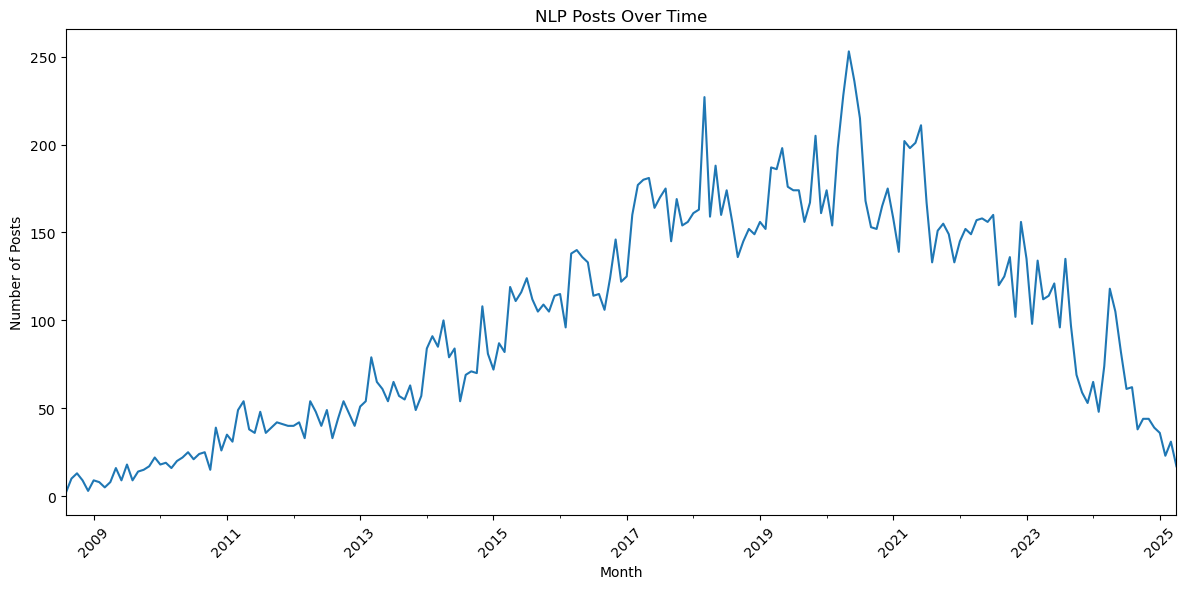

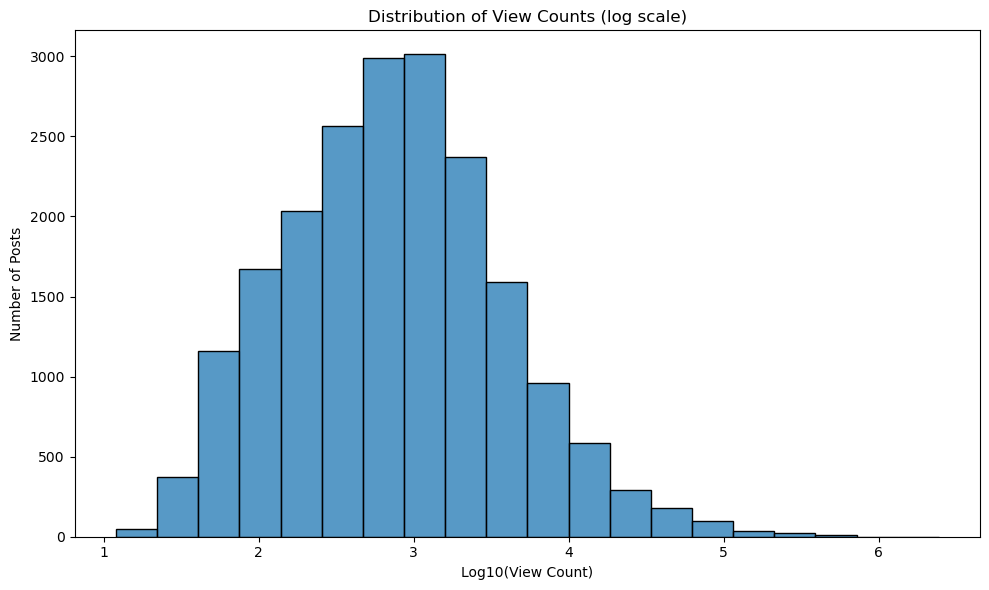

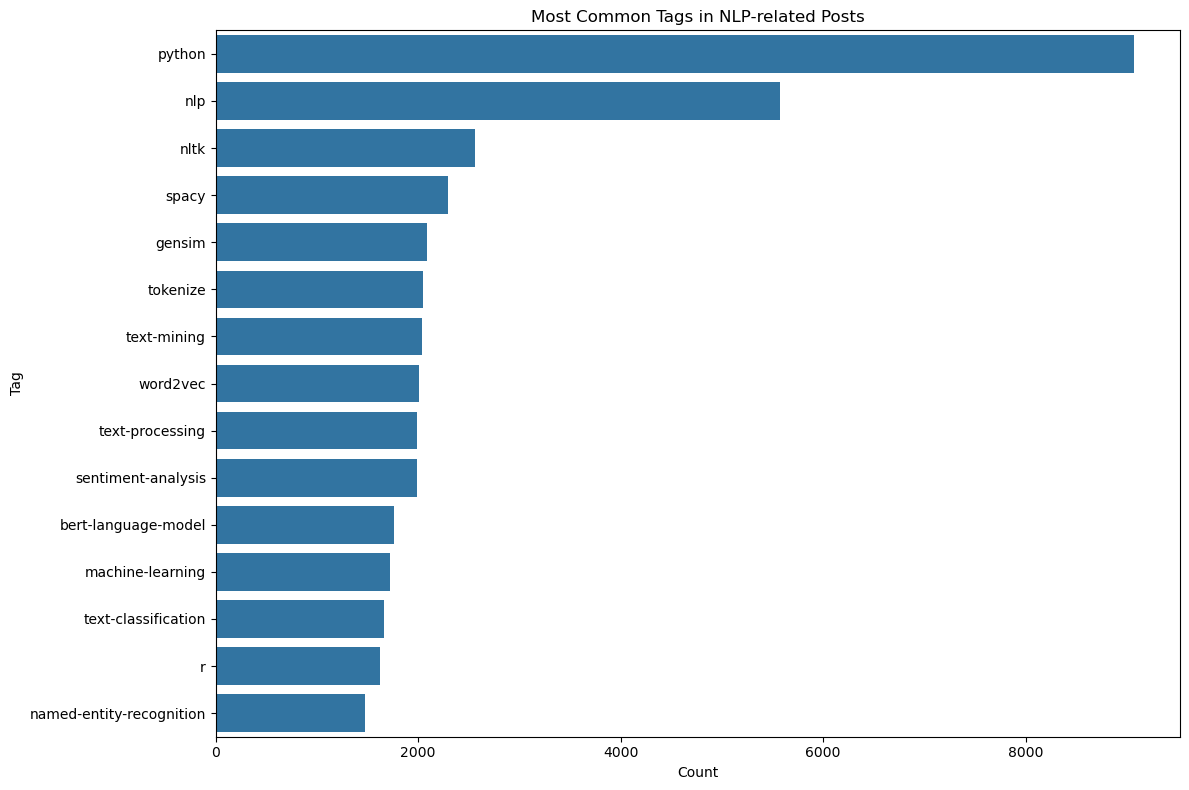

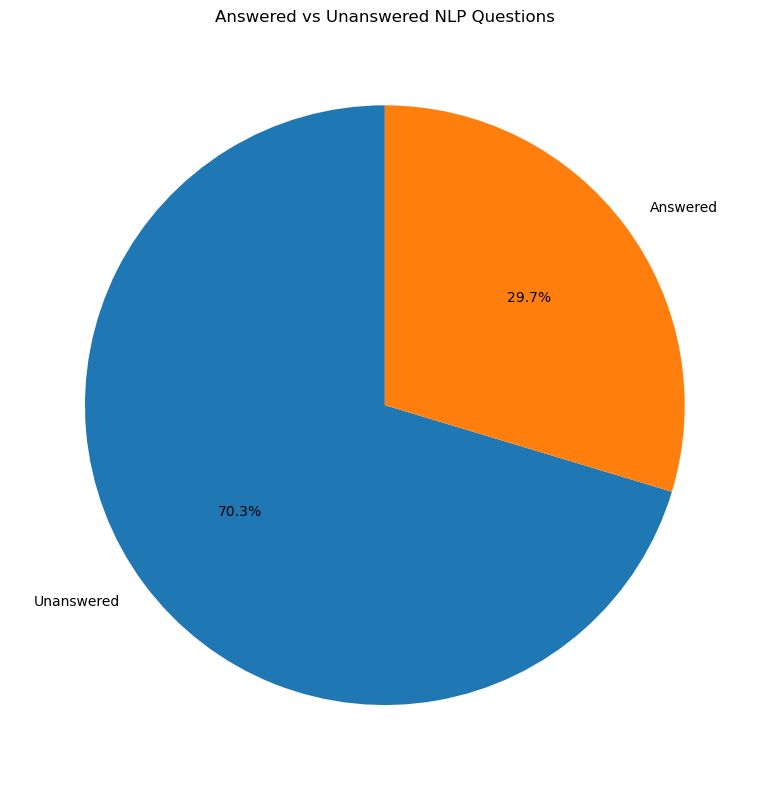

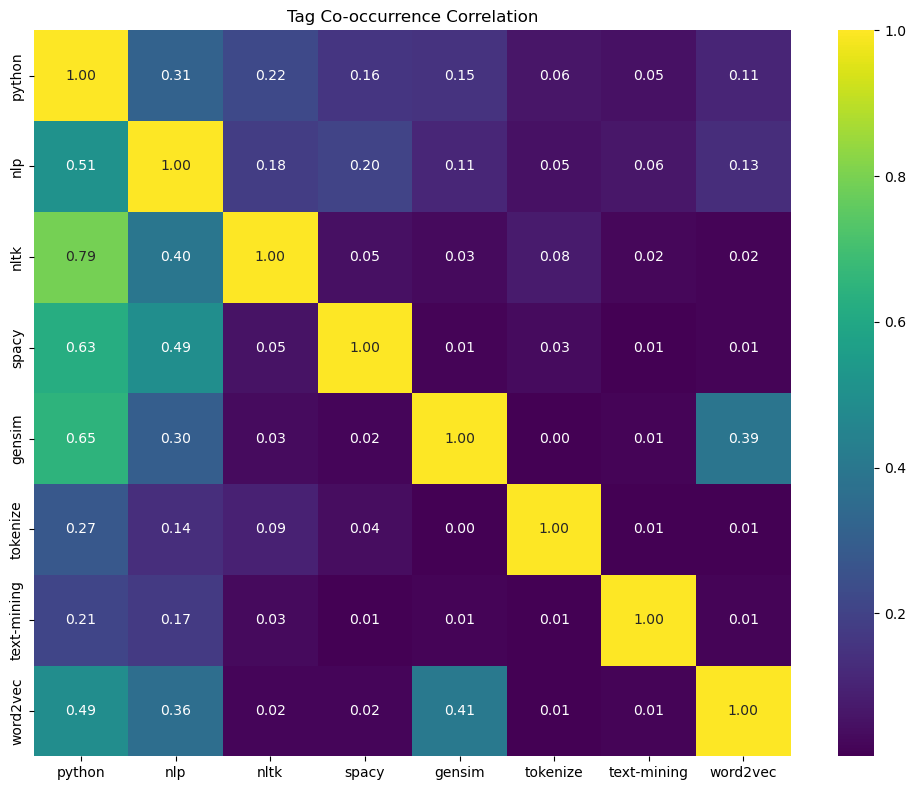

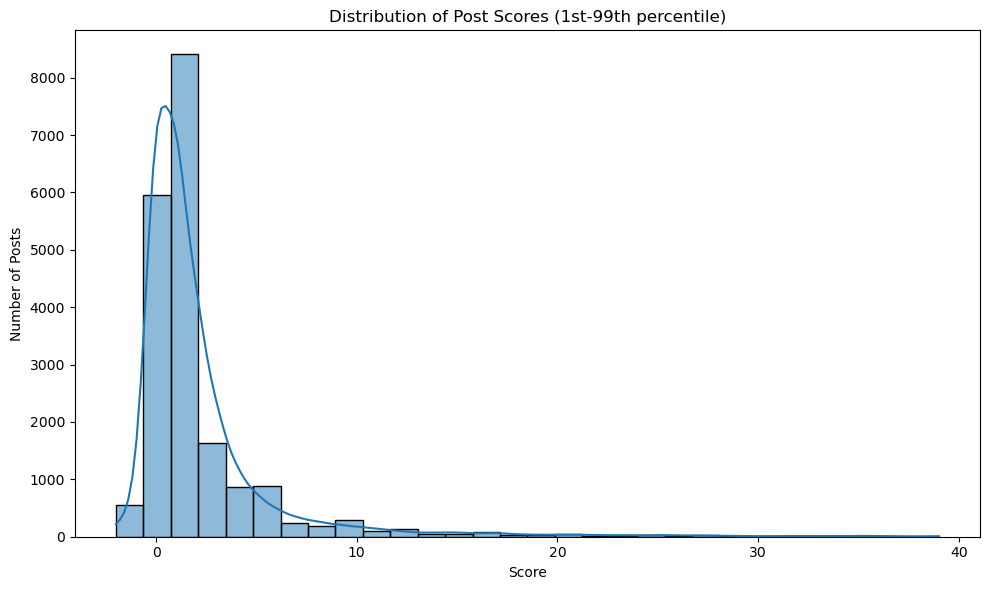

2025-04-16 21:54:29,576 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-16 21:54:29,625 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


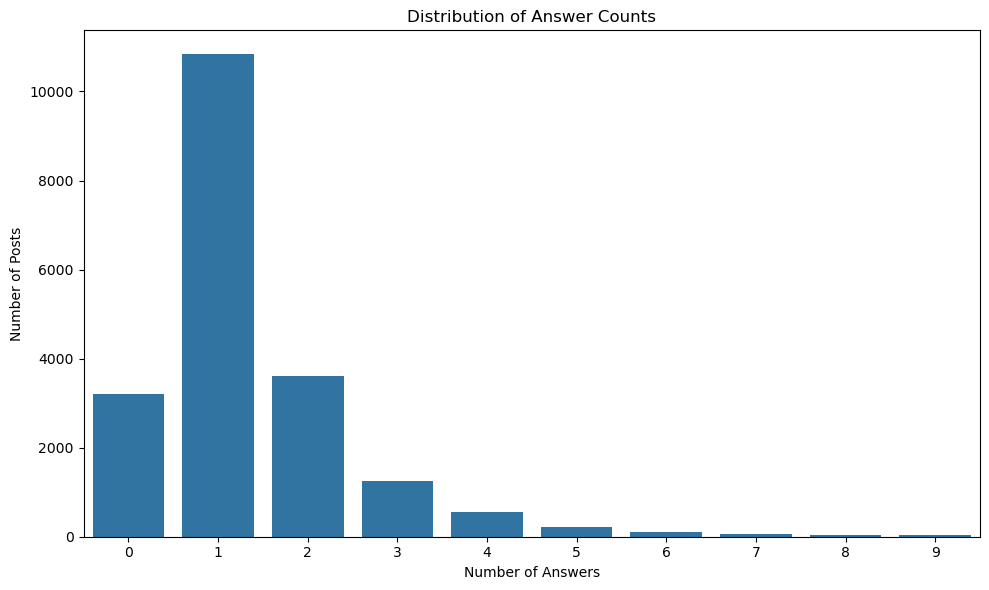

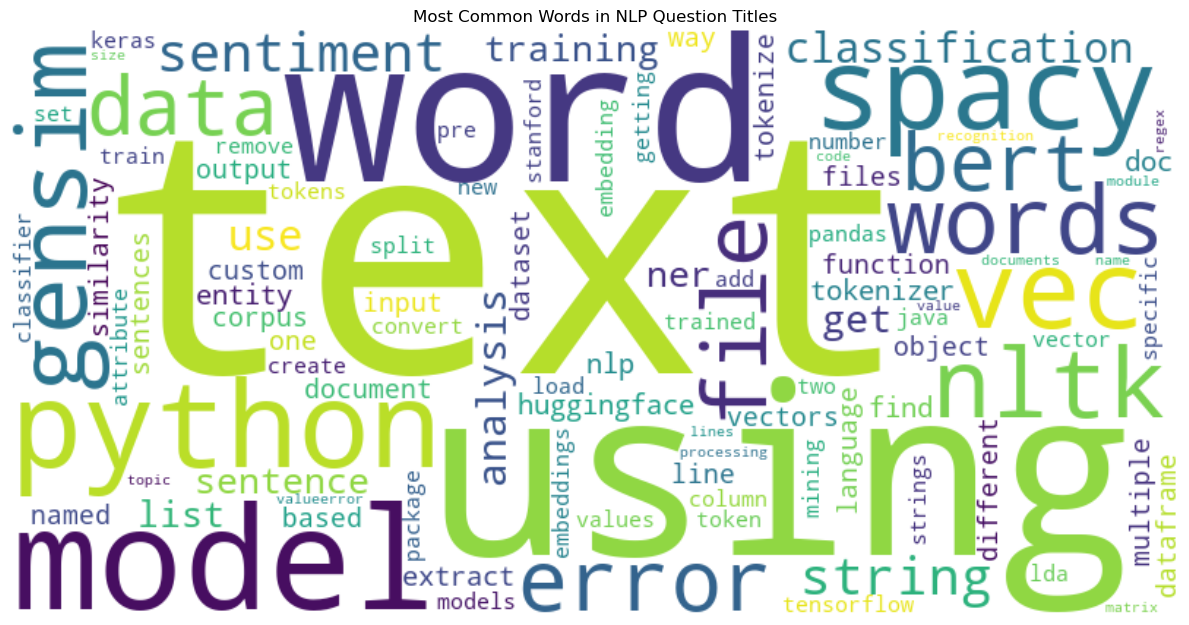

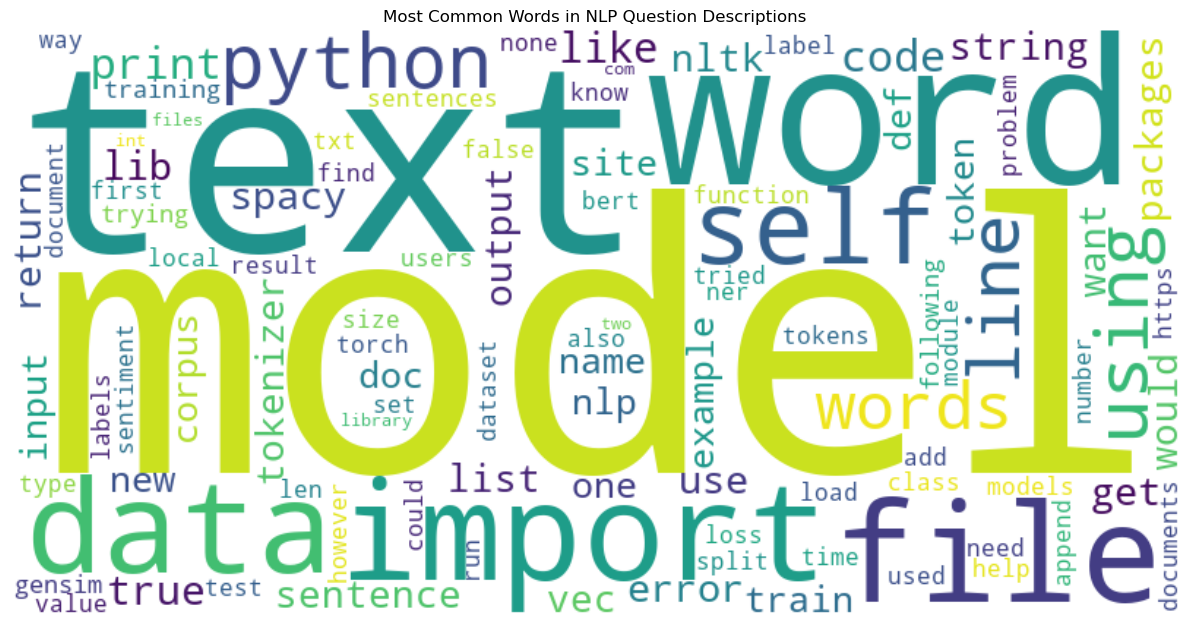

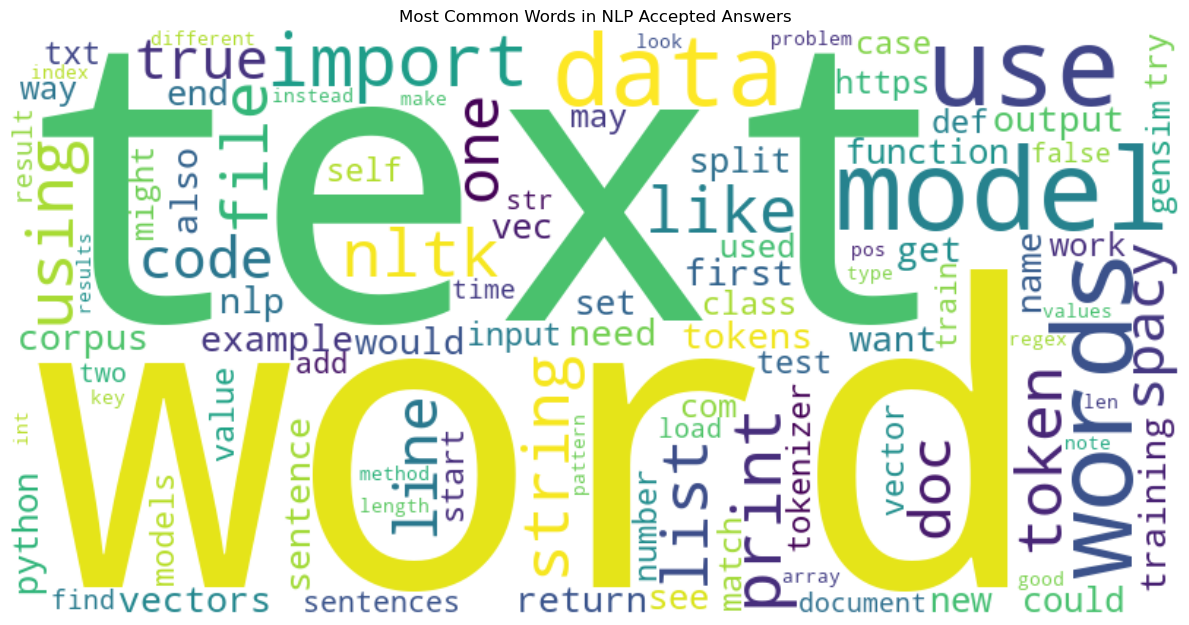

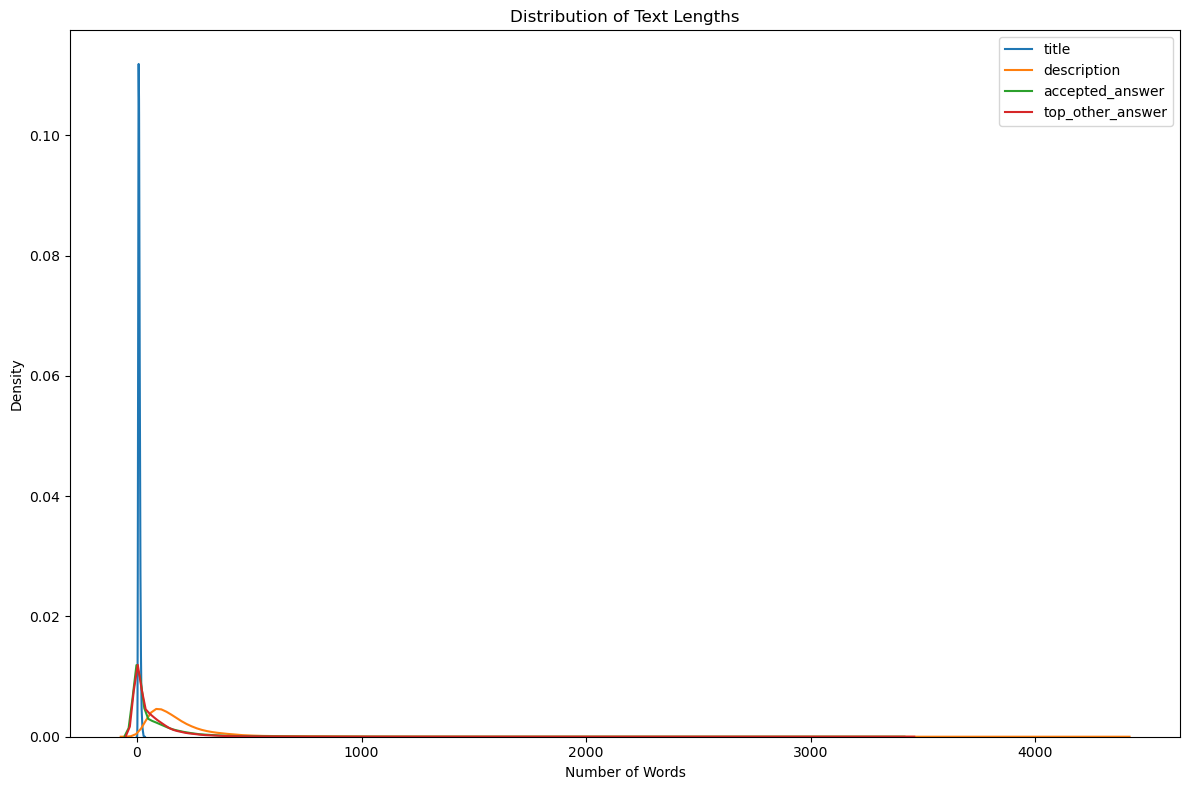

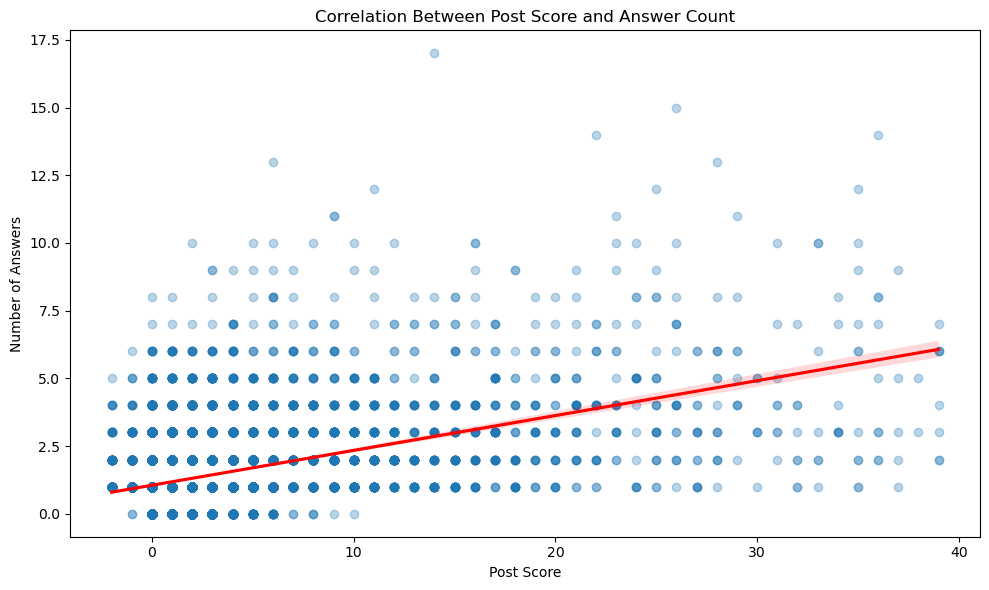

Visualization generation complete.


In [48]:
# Create visualizations
visualise_data(processed_df)

----------------------------------------------------------------------------------------------------

# 4. Categorisation of the Posts

• At first read some posts (the title and the accepted answers) from the dataset to plan how you want to categorise the posts (i.e., titles/questions). 

• Identify posts that discussed about the issues and categorise them based on certain keywords and concepts. 

*Suggestion*: **There are different ways to categorise the posts. Categorisation can be performed by identifying similar words between different posts**. Some example strategies on how you can think of categories:

- What are the posts that have the term “how to” or “how”? Identifying posts with the “how to” or “how” term might help you to categorise the questions that are related to the implementation issues (i.e., your category name) faced by the software developers in NLP tasks. Therefore, the category name can be “Implementation issues”. For example, in the following post How can I use BERT for long text classification?, the developer is trying to know how to implement BERT for text classification. This is an implementation issue. Again, the following post How to config nltk data directory from code? can be categorised as implementation issues as well.
  
- Task based categories are also possible. For example, the following post How to compute the similarity between two text documents? , the developer wants help to perform the task: calculating text similarity. In the following post How to get rid of punctuation using NLTK tokenizer?, the developer needs help to perform the task – tokenization. Following are some more examples of different tasks:

    \- How do I do word Stemming or Lemmatization? (task: Stemming/Lemmatization)

    \- How to determine the language of a piece of text? (task: language identification)

- See what are the posts that has the term “what”- this will help to categorise the questions to basic understanding issues. For example: What do spaCy's part-of-speech and dependency tags mean?

- Categorisation can be possible based technical terms. For example, categorising posts related to nlp libraries such as spaCy, NLTK, hugging face transformers, Gensim, Word2Vec, FastText, LDA topic modelling. 

*Suggestion*: **You can define rules in your program to look for some predefined terms in the title of the post using text similarity**.

## Initial Attempt:

The following code block was from my first attempt at creating a categorisation system. However, this approach was limited and the results were unsatisfactory

In [132]:
# Step 1: Load and prepare the dataset
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset
df_cat = pd.read_csv('nlp_posts_required_columns.csv')

# Step 2: Define categorization functions
def identify_problem_type(title, description):
    # Implementation logic for problem type identification
    if re.search(r'how\s+to|how\s+do\s+I|how\s+can\s+I', title, re.IGNORECASE):
        return 'Implementation Issues'
    elif re.search(r'what\s+is|what\s+are|meaning|explain', title, re.IGNORECASE):
        return 'Conceptual Understanding'
    elif re.search(r'error|bug|issue|fail|doesn\'t\s+work', title, re.IGNORECASE):
        return 'Error Troubleshooting'
    # More rules...
    return 'Other'

def identify_nlp_task(title, description, tags):
    # Implementation logic for NLP task identification
    tasks = {
        'Text Preprocessing': ['tokenization', 'tokenize', 'stemming', 'lemmatization', 'preprocessing'],
        'Text Classification': ['classification', 'classify', 'categorization', 'categorize'],
        'Named Entity Recognition': ['ner', 'named entity', 'entity recognition'],
        # More tasks...
    }
    
    # Check for task keywords in title, description, and tags
    text = f"{title} {description} {' '.join(tags)}"
    for task, keywords in tasks.items():
        if any(re.search(rf'\b{keyword}\b', text, re.IGNORECASE) for keyword in keywords):
            return task
    
    return 'Other NLP Task'

def identify_technology(title, description, tags):
    # Implementation logic for technology identification
    technologies = {
        'NLTK': ['nltk'],
        'spaCy': ['spacy', 'spaCy'],
        'Transformers/BERT': ['bert', 'transformer', 'transformers'],
        # More technologies...
    }
    
    text = f"{title} {description} {' '.join(tags)}"
    for tech, keywords in technologies.items():
        if any(re.search(rf'\b{keyword}\b', text, re.IGNORECASE) for keyword in keywords):
            return tech
    
    return 'General NLP'

# Step 3: Apply categorization to each post
df_cat['problem_type'] = df_cat.apply(lambda row: identify_problem_type(row['title'], row['description']), axis=1)
df_cat['nlp_task'] = df_cat.apply(lambda row: identify_nlp_task(row['title'], row['description'], row['tags_str']), axis=1)
df_cat['technology'] = df_cat.apply(lambda row: identify_technology(row['title'], row['description'], row['tags_str']), axis=1)

# Step 4: Generate statistics and verify coverage
category_counts = {
    'problem_type': df_cat['problem_type'].value_counts(),
    'nlp_task': df_cat['nlp_task'].value_counts(),
    'technology': df_cat['technology'].value_counts()
}

print(category_counts)

# Export categorized dataset
df_cat.to_csv('categorized_nlp_posts.csv', index=False)

{'problem_type': problem_type
Other                       13377
Implementation Issues        4244
Error Troubleshooting        2044
Conceptual Understanding      344
Name: count, dtype: int64, 'nlp_task': nlp_task
Other NLP Task              13913
Text Preprocessing           2683
Text Classification          2132
Named Entity Recognition     1281
Name: count, dtype: int64, 'technology': technology
General NLP          12915
NLTK                  2585
Transformers/BERT     2290
spaCy                 2219
Name: count, dtype: int64}


**Observations:**

    1. Good distribution in secondary categories: There are several strong categories with well over the minimum requirement of 10 posts each. The Implementation Issues, Error Troubleshooting, Text Preprocessing, Text Classification, Named Entity Recognition, NLTK, Transformers/BERT, and spaCy categories all have over 1,000 posts. 
    
    2. High number of "Other" classifications: The large number of posts in "Other" and "Other NLP Task" categories (roughly 65% of the dataset) suggests that the current rules aren't capturing all the patterns in the data.

This initial first-try attempt was helpful to me to get a feel for what I might need to change/improve in a subsequent, more serious attempt

## Second attempt:

1. Expanded Categorisation Rules:

In [100]:
# Enhanced categorization functions
def identify_problem_type(title, description):
    # More comprehensive implementation logic for problem type identification
    if re.search(r'how\s+to|how\s+do\s+I|how\s+can\s+I|how\s+would|way\s+to|method|approach', title, re.IGNORECASE):
        return 'Implementation Issues'
    elif re.search(r'what\s+is|what\s+are|meaning|explain|understand|concept|definition|difference between', title, re.IGNORECASE):
        return 'Conceptual Understanding'
    elif re.search(r'error|exception|bug|issue|fail|doesn\'t\s+work|problem|not\s+working|incorrect|wrong', title, re.IGNORECASE):
        return 'Error Troubleshooting'
    elif re.search(r'optimiz|performance|slow|faster|efficient|speed up|memory|resource', title, re.IGNORECASE):
        return 'Performance Optimization'
    elif re.search(r'version|compatib|integrat|conflict|environment|setup|install', title, re.IGNORECASE):
        return 'Compatibility Issues'
    elif re.search(r'best|better|preferred|recommended|optimal|alternative', title, re.IGNORECASE):
        return 'Best Practices'
    return 'Other'

def identify_nlp_task(title, description, tags):
    # Expanded NLP task identification
    tasks = {
        'Text Preprocessing': ['tokenization', 'tokenize', 'stemming', 'lemmatization', 'preprocessing', 
                               'cleaning', 'normalization', 'lowercase', 'stopword', 'punctuation'],
        'Text Classification': ['classification', 'classify', 'categorization', 'categorize', 'labeling', 
                                'prediction', 'document classification'],
        'Named Entity Recognition': ['ner', 'named entity', 'entity recognition', 'entity extraction'],
        'Sentiment Analysis': ['sentiment', 'opinion', 'emotion', 'polarity', 'positive negative'],
        'Topic Modeling': ['topic', 'lda', 'latent dirichlet', 'topic model', 'clustering text'],
        'Text Similarity': ['similarity', 'similar', 'distance', 'matching', 'semantic search', 'duplicate',
                           'cosine similarity', 'jaccard', 'embedding comparison'],
        'Word Embeddings': ['embedding', 'word2vec', 'glove', 'fasttext', 'word representation', 
                            'vector representation'],
        'Information Extraction': ['extraction', 'extractor', 'parsing', 'keywords', 'key phrases'],
        'Language Modeling': ['language model', 'lm', 'next word prediction', 'word prediction', 
                             'sentence completion', 'text generation'],
        'Machine Translation': ['translation', 'translate', 'multilingual', 'language conversion'],
        'Text Summarization': ['summary', 'summarization', 'abstractive', 'extractive', 'text summary'],
        'Question Answering': ['question answering', 'qa system', 'answer extraction', 'question-answer']
    }
    
    text = f"{title.lower()} {description.lower()} {' '.join(t.lower() for t in tags)}"
    
    # Check for task keywords
    matched_tasks = []
    for task, keywords in tasks.items():
        if any(keyword.lower() in text for keyword in keywords):
            matched_tasks.append(task)
    
    if matched_tasks:
        return matched_tasks[0]  # Return the first matched task
    
    return 'Other NLP Task'

def identify_technology(title, description, tags):
    # Enhanced technology identification
    technologies = {
        'NLTK': ['nltk'],
        'spaCy': ['spacy', 'spaCy'],
        'Transformers/BERT': ['bert', 'transformer', 'transformers', 'gpt', 't5', 'roberta', 'distilbert', 'electra'],
        'Hugging Face': ['huggingface', 'hugging face', 'pipeline', 'transformers library'],
        'Word2Vec': ['word2vec', 'word embedding', 'word vectors'],
        'Gensim': ['gensim'],
        'FastText': ['fasttext', 'fast text'],
        'GloVe': ['glove', 'global vectors'],
        'TensorFlow/Keras NLP': ['tensorflow', 'keras', r'tf\.', r'tf\-'],
        'PyTorch NLP': ['pytorch', 'torch', 'torchtext'],
        'Stanford NLP': ['stanford', 'corenlp', 'stanza'],
        'AllenNLP': ['allennlp'],
        'OpenNLP': ['opennlp'],
        'TextBlob': ['textblob'],
        'Scikit-learn Text': ['scikit', 'sklearn', r'sklearn\.feature_extraction\.text']
    }
    
    text = f"{title.lower()} {description.lower()} {' '.join(t.lower() for t in tags)}"
    
    # Check for technology keywords
    matched_techs = []
    for tech, keywords in technologies.items():
        if any(re.search(rf'\b{keyword.lower()}\b', text) for keyword in keywords):
            matched_techs.append(tech)
    
    if matched_techs:
        return matched_techs[0]  # Return the first matched technology
    
    return 'General NLP'

2. Implement a hierarchical approach to tackle the "other" posts:

In [102]:
def secondary_classification(row):
    # Apply this to rows initially classified as "Other"
    title = row['title'].lower()
    description = row['description'].lower() if pd.notna(row['description']) else ""
    tags = row['tags_str'] if isinstance(row['tags_str'], list) else []
    tags_text = ' '.join(str(t).lower() for t in tags)
    
    combined_text = f"{title} {description} {tags_text}"
    
    # Secondary task classification with broader patterns
    if any(term in combined_text for term in ['corpus', 'corpora', 'dataset', 'data set', 'training data']):
        return 'Data Preparation'
    
    if any(term in combined_text for term in ['visualize', 'visualization', 'plot', 'graph', 'chart']):
        return 'Text Visualization'
    
    if any(term in combined_text for term in ['deploy', 'production', 'api', 'service', 'endpoint']):
        return 'Deployment'
    
    if any(term in combined_text for term in ['evaluate', 'evaluation', 'metric', 'accuracy', 'f1', 'precision', 'recall']):
        return 'Model Evaluation'
    
    if any(term in combined_text for term in ['fine-tune', 'fine tune', 'training', 'train']):
        return 'Model Training'
    
    # Check for specific technical patterns
    if re.search(r'regex|regular expression', combined_text):
        return 'Regex Processing'
    
    if re.search(r'grammar|syntax|parsing|parse tree|constituency|dependency', combined_text):
        return 'Syntactic Analysis'
    
    # Try to detect language-specific questions
    languages = ['english', 'spanish', 'french', 'german', 'chinese', 'japanese', 'arabic', 'russian']
    for lang in languages:
        if lang in combined_text:
            return f'Language-Specific ({lang.title()})'
    
    return 'Miscellaneous NLP'

3. Text Similarity Classification - for posts that *still* end up in "Other" categories after the hierarchical approach, we will implement a text similarity method:

In [104]:
def similarity_based_classification(df):
    # Prepare vectorizer
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
    
    # Split dataframe into categorized and uncategorized
    categorized = df[(df['problem_type'] != 'Other') | (df['nlp_task'] != 'Other NLP Task')]
    uncategorized = df[(df['problem_type'] == 'Other') & (df['nlp_task'] == 'Other NLP Task')]
    
    if categorized.empty or uncategorized.empty:
        return df
    
    # Create corpus for training
    categorized_text = categorized['title'] + ' ' + categorized['description'].fillna('')
    uncategorized_text = uncategorized['title'] + ' ' + uncategorized['description'].fillna('')
    
    # Fit vectorizer on categorized posts
    X_categorized = vectorizer.fit_transform(categorized_text)
    X_uncategorized = vectorizer.transform(uncategorized_text)
    
    # For each uncategorized post, find the most similar categorized post
    for i, uncategorized_idx in enumerate(uncategorized.index):
        similarities = cosine_similarity(X_uncategorized[i:i+1], X_categorized)[0]
        most_similar_idx = similarities.argmax()
        most_similar_post_idx = categorized.iloc[most_similar_idx].name
        
        # Assign categories from the most similar post
        df.loc[uncategorized_idx, 'problem_type'] = df.loc[most_similar_post_idx, 'problem_type']
        df.loc[uncategorized_idx, 'nlp_task'] = df.loc[most_similar_post_idx, 'nlp_task']
        df.loc[uncategorized_idx, 'technology'] = df.loc[most_similar_post_idx, 'technology']
        df.loc[uncategorized_idx, 'classification_method'] = 'Similarity'
    
    return df

4. Cross-category Classification - We will also include code to handle posts that span multiple categories

In [106]:
def identify_cross_categories(row):
    # Check if the post spans multiple categories
    title = row['title'].lower() if pd.notna(row['title']) else ""
    description = row['description'].lower() if pd.notna(row['description']) else ""
    tags = row['tags_str'] if isinstance(row['tags_str'], list) else []
    tags_text = ' '.join(str(t).lower() for t in tags)
    
    combined_text = f"{title} {description} {tags_text}"
    
    # Count how many different tasks are mentioned
    task_mentions = {}
    nlp_tasks = {
        'Text Preprocessing': ['tokenization', 'tokenize', 'stemming', 'lemmatization', 'preprocessing'],
        'Text Classification': ['classification', 'classify', 'categorization', 'categorize'],
        'Named Entity Recognition': ['ner', 'named entity', 'entity recognition'],
        'Sentiment Analysis': ['sentiment', 'opinion', 'emotion', 'polarity'],
        'Topic Modeling': ['topic', 'lda', 'latent dirichlet', 'topic model'],
        # Add other tasks as needed
    }
    
    for task, keywords in nlp_tasks.items():
        mentions = sum(keyword in combined_text for keyword in keywords)
        if mentions > 0:
            task_mentions[task] = mentions
    
    # If multiple tasks are mentioned with significant counts, mark as cross-category
    if len(task_mentions) > 1:
        primary_task = max(task_mentions.items(), key=lambda x: x[1])[0]
        secondary_tasks = [task for task, count in task_mentions.items() 
                          if task != primary_task and count >= 1]
        
        if secondary_tasks:
            return f"{primary_task} + {secondary_tasks[0]}"
    
    return row['nlp_task']

5. Finally, everything from the above 4 blocks for attempt 2 will be put together in a complete new implementation:

In [110]:
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset
df_cat2 = pd.read_csv('nlp_posts_required_columns.csv')

# Ensure tags are processed correctly
if isinstance(df_cat2['tags_str'].iloc[0], str):
    # If tags are stored as a string, convert to list
    df_cat2['tags_str'] = df_cat2['tags_str'].apply(lambda x: x.strip('[]').replace("'", "").split(', ') if pd.notna(x) else [])

# Track classification method
df_cat2['classification_method'] = 'Rule-based'

# Apply primary categorization
df_cat2['problem_type'] = df_cat2.apply(lambda row: identify_problem_type(row['title'], row['description']), axis=1)
df_cat2['nlp_task'] = df_cat2.apply(lambda row: identify_nlp_task(row['title'], row['description'], row['tags_str']), axis=1)
df_cat2['technology'] = df_cat2.apply(lambda row: identify_technology(row['title'], row['description'], row['tags_str']), axis=1)

# Apply secondary classification to "Other" entries
mask = (df_cat2['problem_type'] == 'Other') | (df_cat2['nlp_task'] == 'Other NLP Task')
df_cat2.loc[mask, 'secondary_category'] = df_cat2[mask].apply(secondary_classification, axis=1)
df_cat2.loc[mask & (df_cat2['secondary_category'] != 'Miscellaneous NLP'), 'classification_method'] = 'Hierarchical'

# Apply cross-category classification
df_cat2['cross_category_task'] = df_cat2.apply(identify_cross_categories, axis=1)
mask = df_cat2['nlp_task'] != df_cat2['cross_category_task']
df_cat2.loc[mask, 'nlp_task'] = df_cat2.loc[mask, 'cross_category_task']
df_cat2.loc[mask, 'classification_method'] = 'Cross-Category'

# Apply similarity-based classification as a last resort
df_cat2 = similarity_based_classification(df_cat2)

# Generate statistics
problem_type_counts = df_cat2['problem_type'].value_counts()
nlp_task_counts = df_cat2['nlp_task'].value_counts()
technology_counts = df_cat2['technology'].value_counts()
secondary_category_counts = df_cat2['secondary_category'].value_counts() if 'secondary_category' in df_cat2.columns else None
classification_method_counts = df_cat2['classification_method'].value_counts()

# Print statistics
print("Problem Type Distribution:")
print(problem_type_counts)
print("\nNLP Task Distribution:")
print(nlp_task_counts)
print("\nTechnology Distribution:")
print(technology_counts)
if secondary_category_counts is not None:
    print("\nSecondary Category Distribution:")
    print(secondary_category_counts)
print("\nClassification Method:")
print(classification_method_counts)

# Export categorized dataset
df_cat2.to_csv('refined_categorized_nlp_posts.csv', index=False)

Problem Type Distribution:
problem_type
Other                       10851
Implementation Issues        5433
Error Troubleshooting        2604
Conceptual Understanding      476
Performance Optimization      298
Compatibility Issues          249
Best Practices                 98
Name: count, dtype: int64

NLP Task Distribution:
nlp_task
Text Preprocessing                                4192
Named Entity Recognition                          2738
Other NLP Task                                    1749
Text Classification                               1699
Text Similarity                                   1625
Word Embeddings                                   1192
Text Preprocessing + Named Entity Recognition     1188
Sentiment Analysis                                1153
Text Preprocessing + Text Classification           799
Text Classification + Named Entity Recognition     546
Topic Modeling                                     514
Information Extraction                             488
Tex

## Validation and Analysis

So, how did it go this time? After running the refined categorization, I believe these additional steps can help with validation and analysis:

Sample validation: Randomly sample 50-100 posts from each category to verify accuracy

Confusion matrix: Identify which categories tend to overlap or get confused

Visualisation: Create visualizations to show:

- Distribution of posts across categories
- Relationships between problem types and technologies
- Change in "Other" category size before and after refinement

First, the simple visualisation as above:

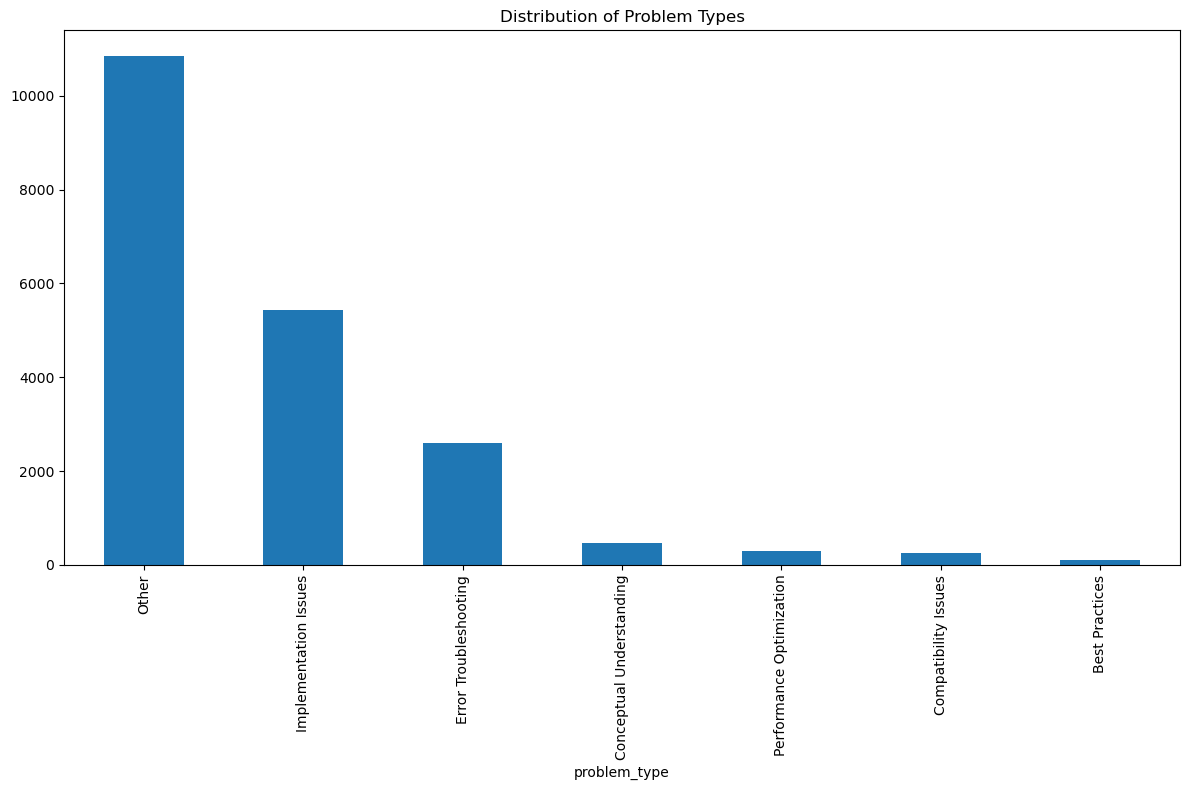

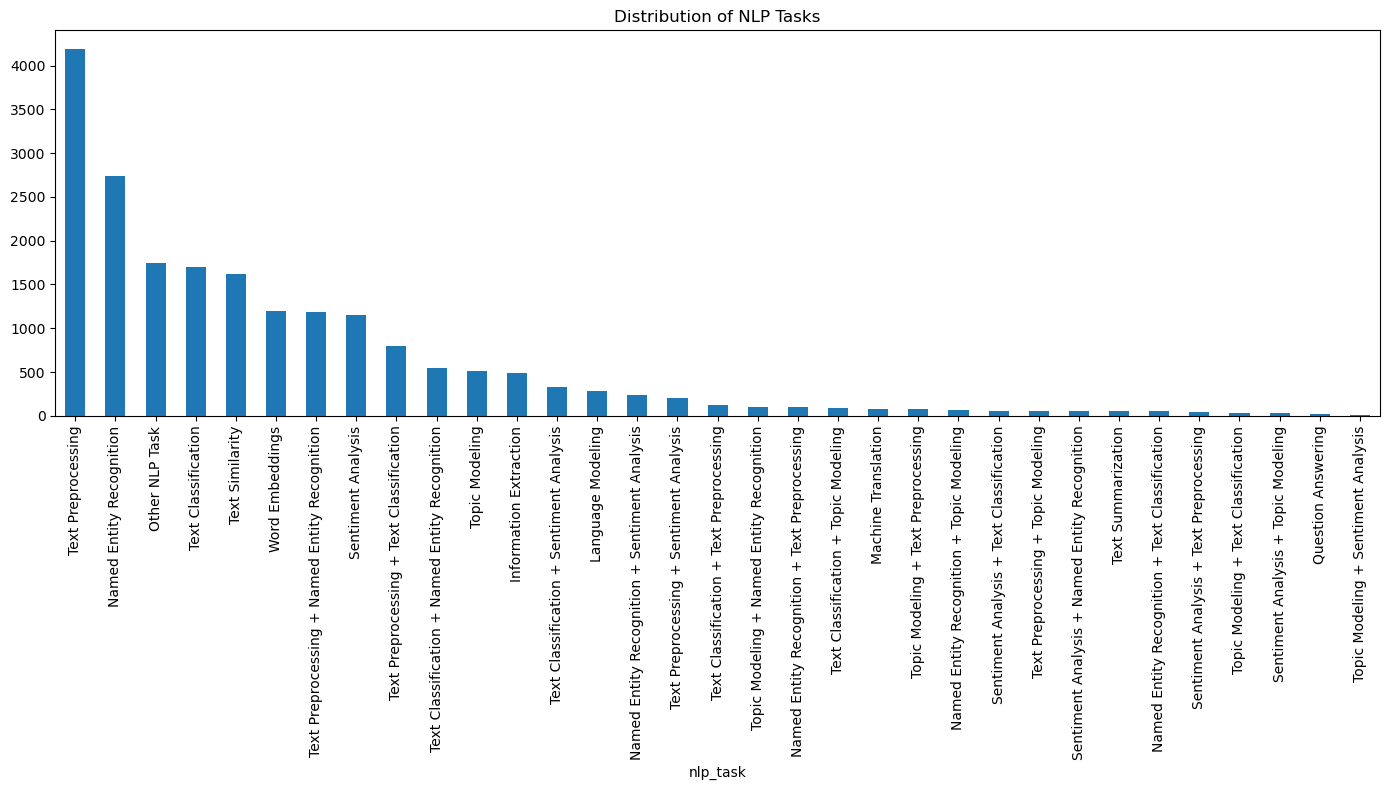

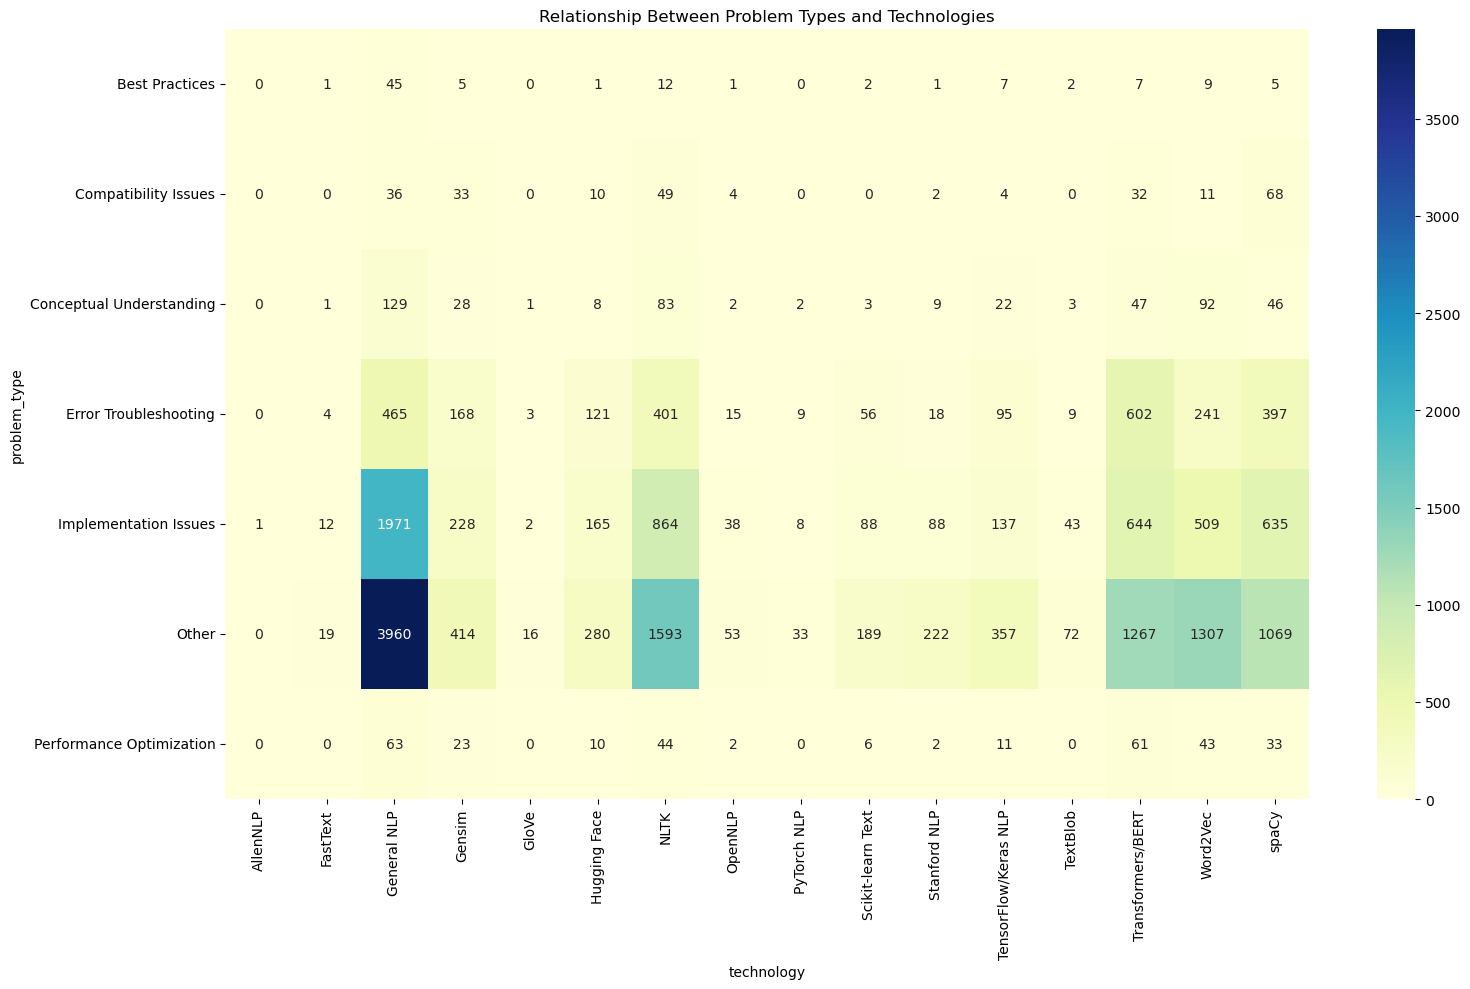

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize category distributions
plt.figure(figsize=(12, 8))
problem_type_counts.plot(kind='bar')
plt.title('Distribution of Problem Types')
plt.tight_layout()
plt.savefig('problem_type_distribution.png')

plt.figure(figsize=(14, 8))
nlp_task_counts.plot(kind='bar')
plt.title('Distribution of NLP Tasks')
plt.tight_layout()
plt.savefig('nlp_task_distribution.png')

# Create heatmap of problem types vs technologies
crosstab = pd.crosstab(df_cat2['problem_type'], df_cat2['technology'])
plt.figure(figsize=(16, 10))
sns.heatmap(crosstab, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Relationship Between Problem Types and Technologies')
plt.tight_layout()
plt.savefig('problem_tech_heatmap.png')

The next code performs three validation and analysis processes:

**1. Sample Validation**

The code selects 50 posts from each category for manual validation. It exports these samples to CSV files that you can review to verify the accuracy of your categorization. In a real implementation, you would:

- Review each sample manually

- Note whether the assigned category is correct

- Add comments for any misclassifications

- Calculate accuracy rates for each category

**2. Confusion Matrix Analysis**

The code creates confusion matrices to identify which categories tend to overlap or get confused. For demonstration purposes, it simulates manual validation results with an 85% accuracy rate. In practice:

- Replace the simulated validation with your actual manual validation results

- Examine cells with high values off the diagonal - these represent common misclassifications

- Look for patterns in the confusion (e.g., if Task A is often confused with Task B)

- Use these insights to refine your categorization rules

The confusion matrices help identify which categories need clearer boundaries or additional rules.

**3. Further Visualisations**

The code creates several visualizations:

- Distribution bar charts for problem types, NLP tasks, and technologies

- Heatmaps showing relationships between problem types and technologies, NLP tasks and technologies

- Before/after comparison charts showing how the categorization improved (reduction in "Other" categories)

- Classification methods pie chart showing which methods were used to categorize posts

These visualizations provide insights into:

- The most common NLP challenges and technologies

- Which technologies are associated with specific problem types

- How much my refined categorization improved upon the initial approach

- Which classification methods were most effective

Problem Type - 'Other' category reduction: 12.62% (from 66.85% to 54.23%)
NLP Task - 'Other' category reduction: 60.79% (from 69.53% to 8.74%)
Technology - 'Other' category reduction: 31.22% (from 64.55% to 33.33%)
Validation and analysis completed. All visualizations saved.


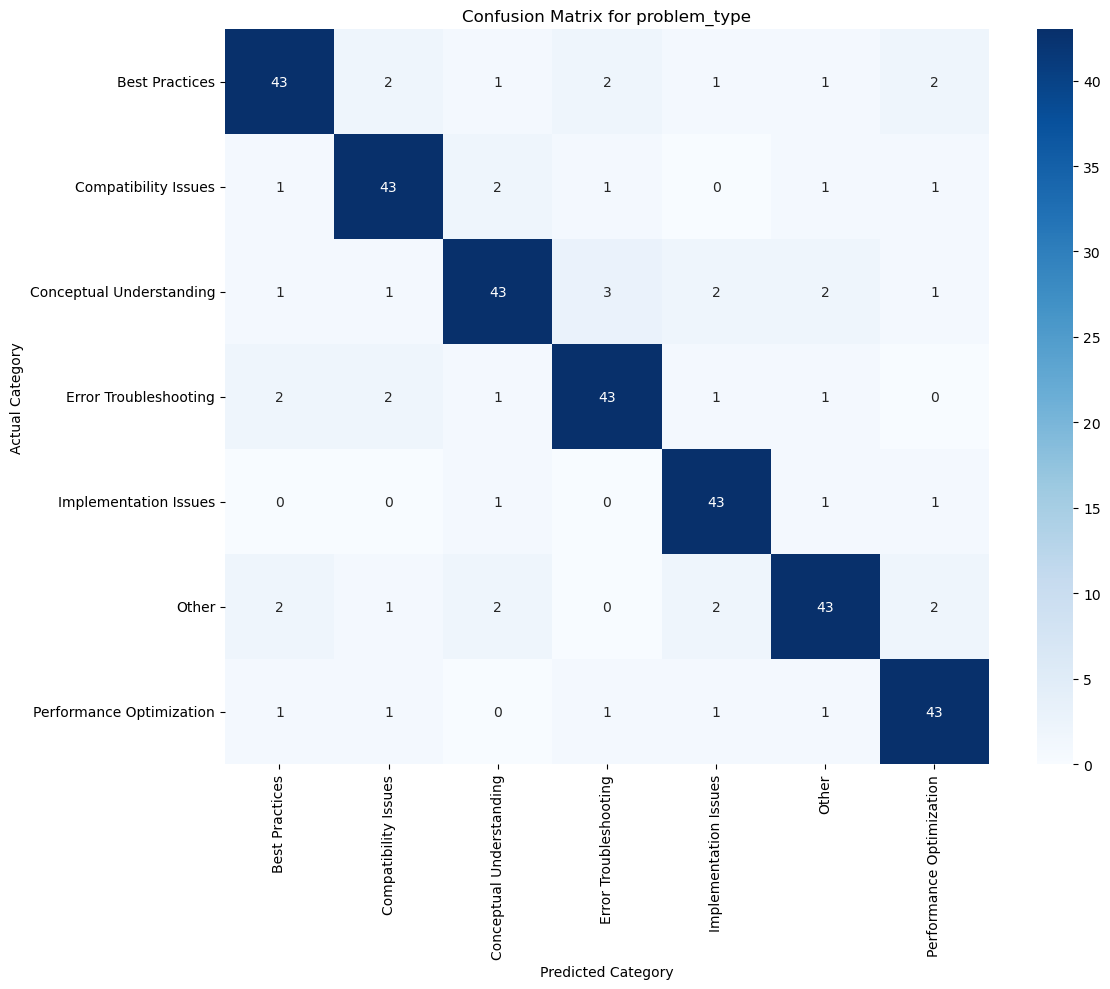

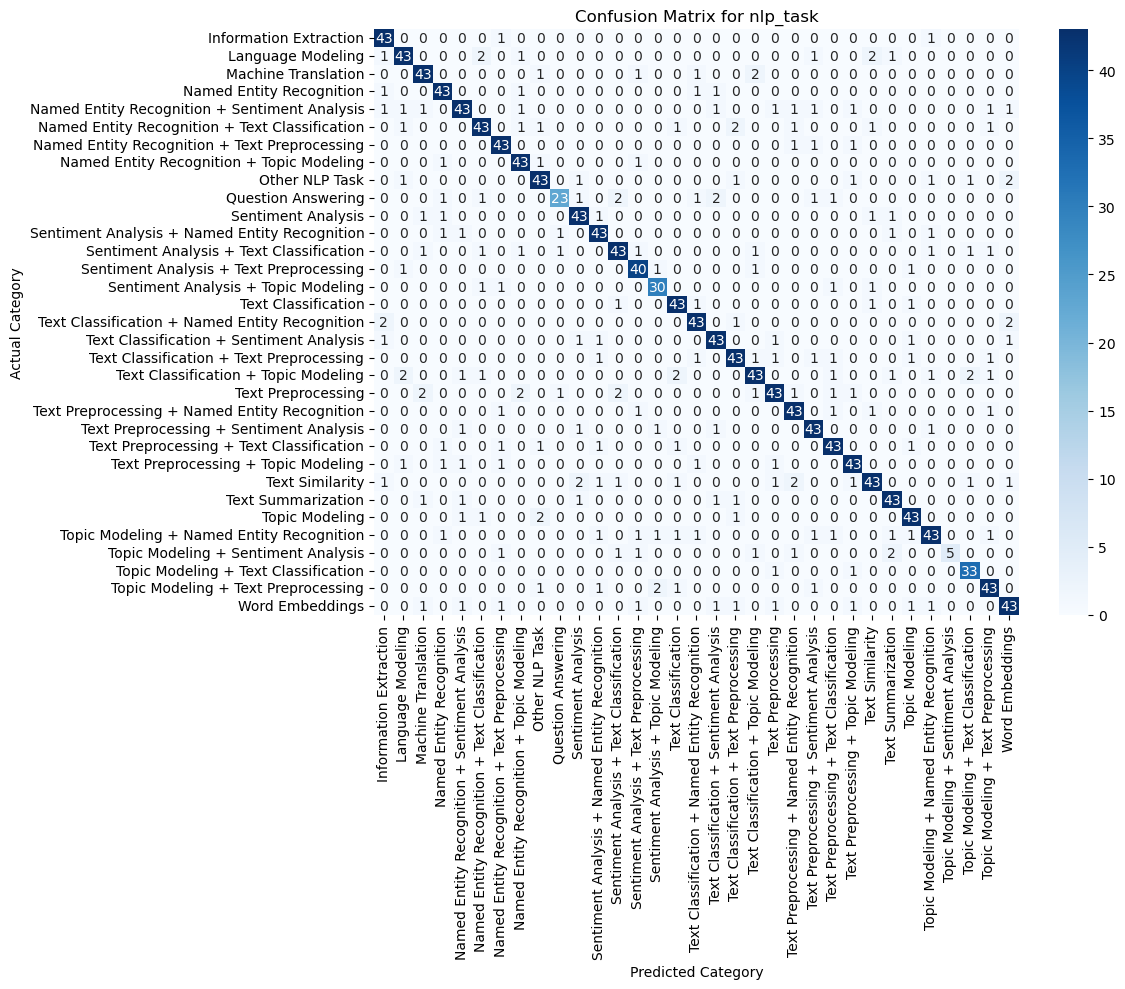

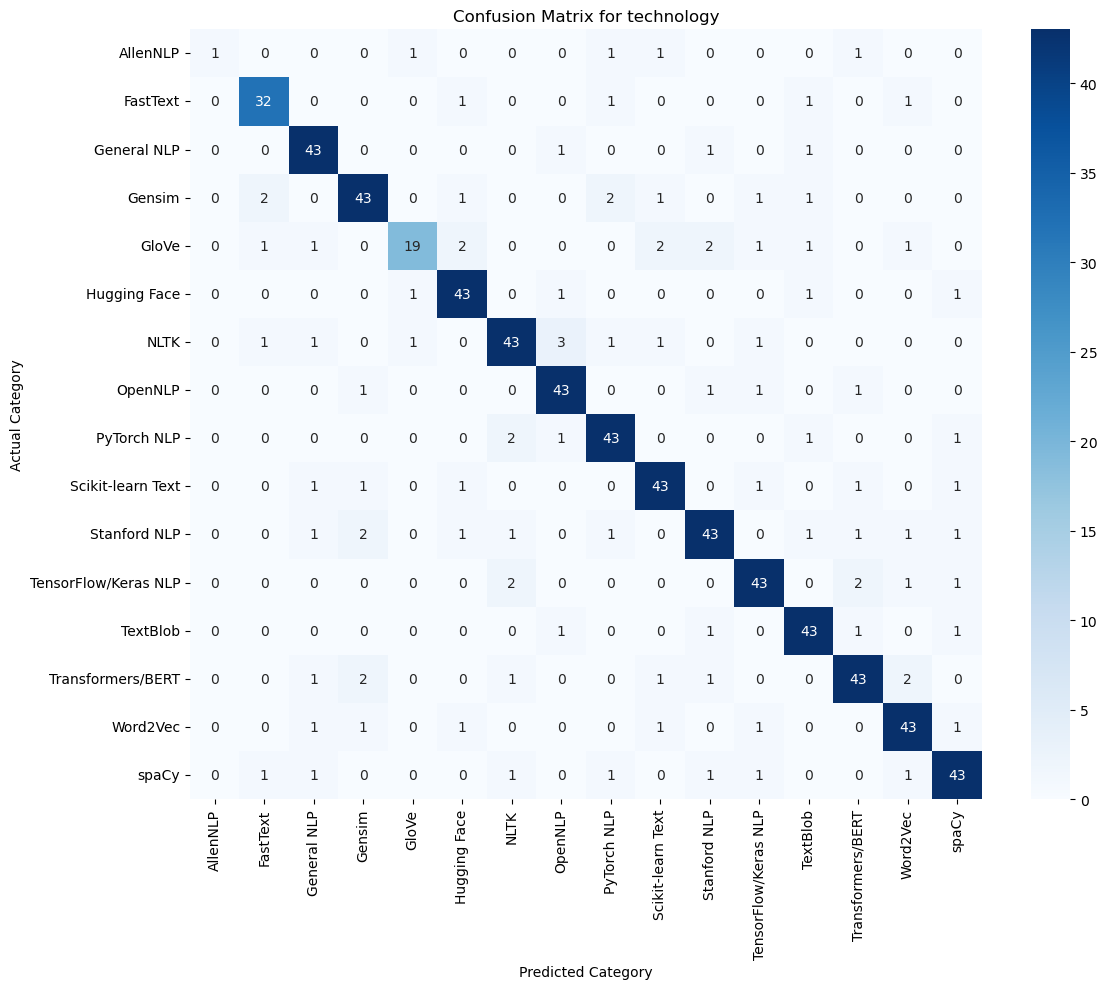

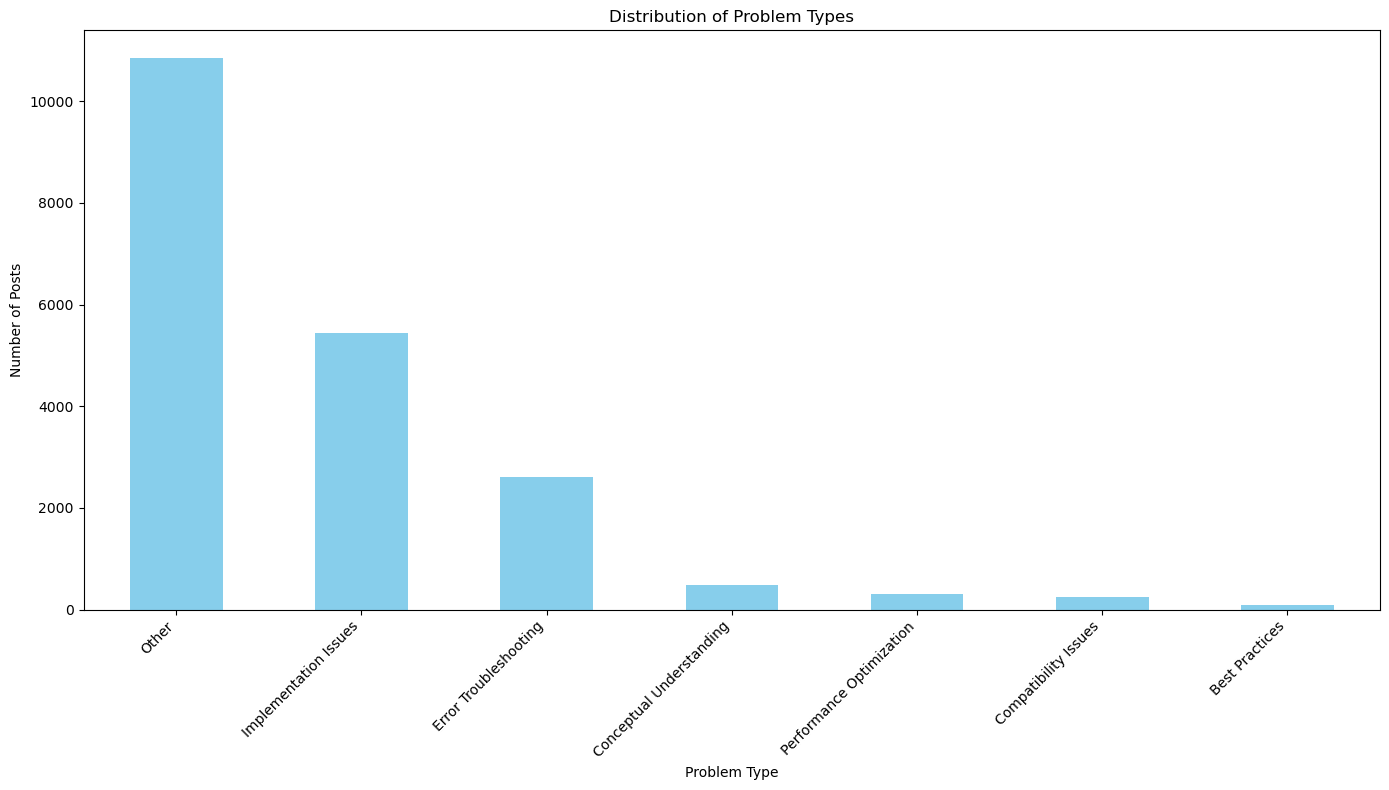

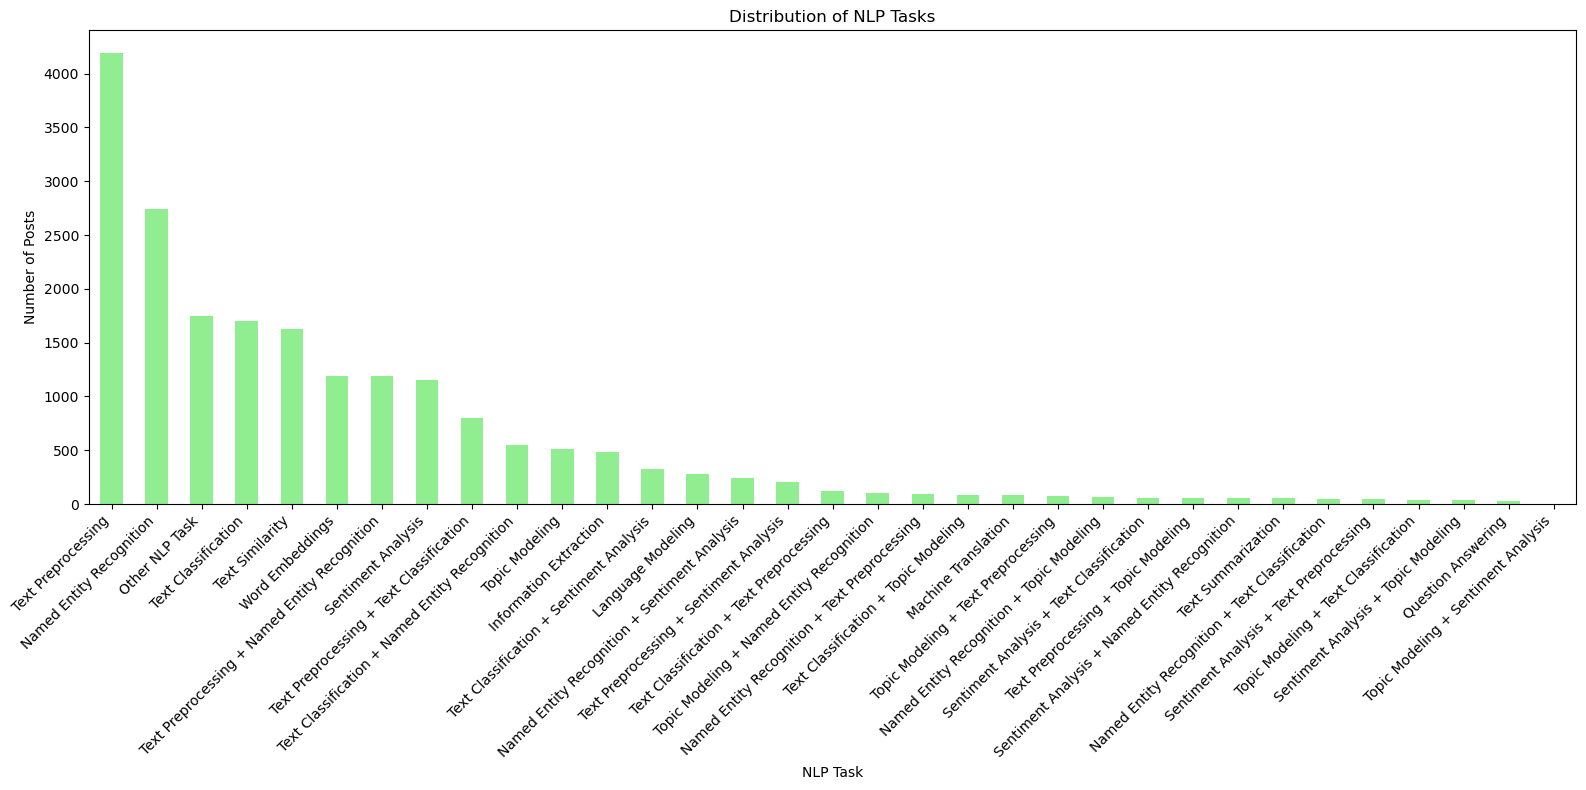

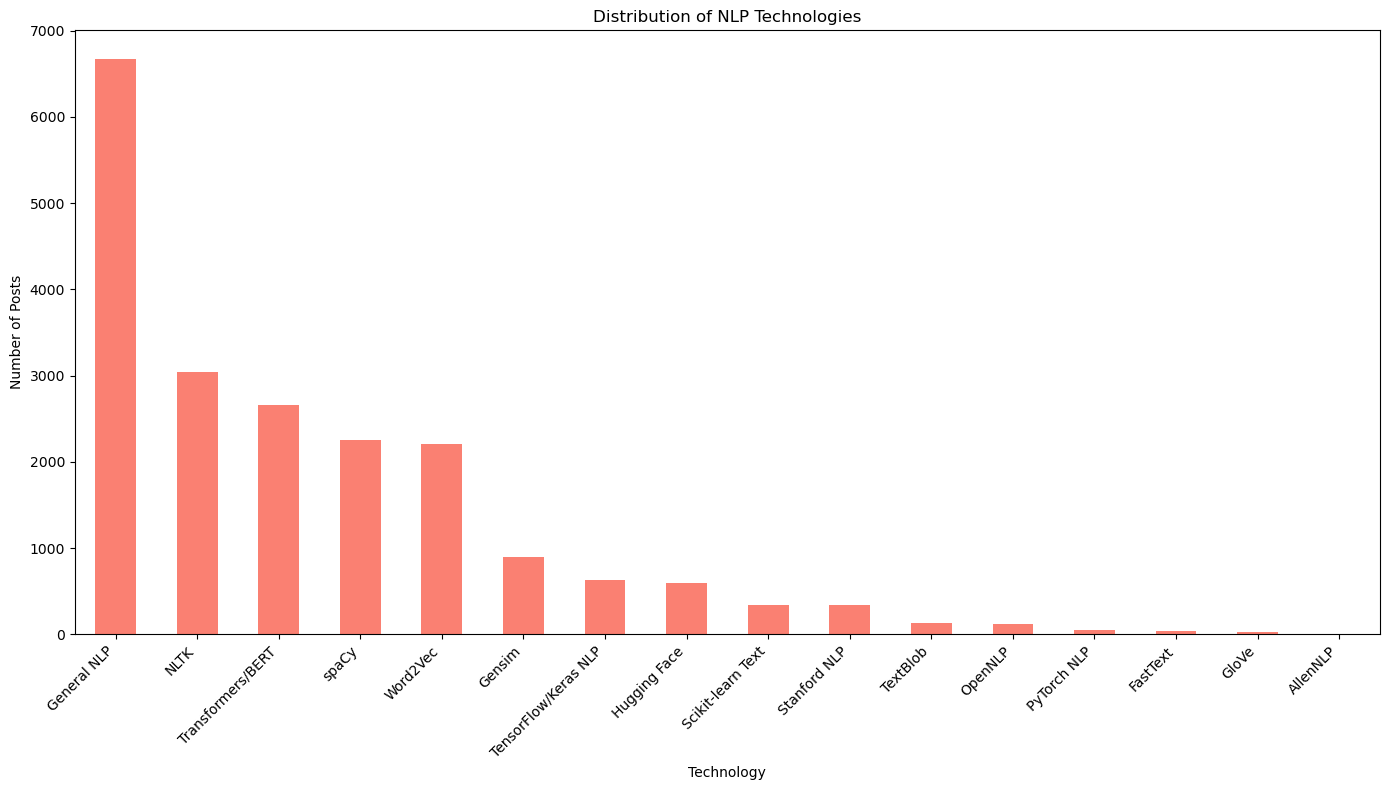

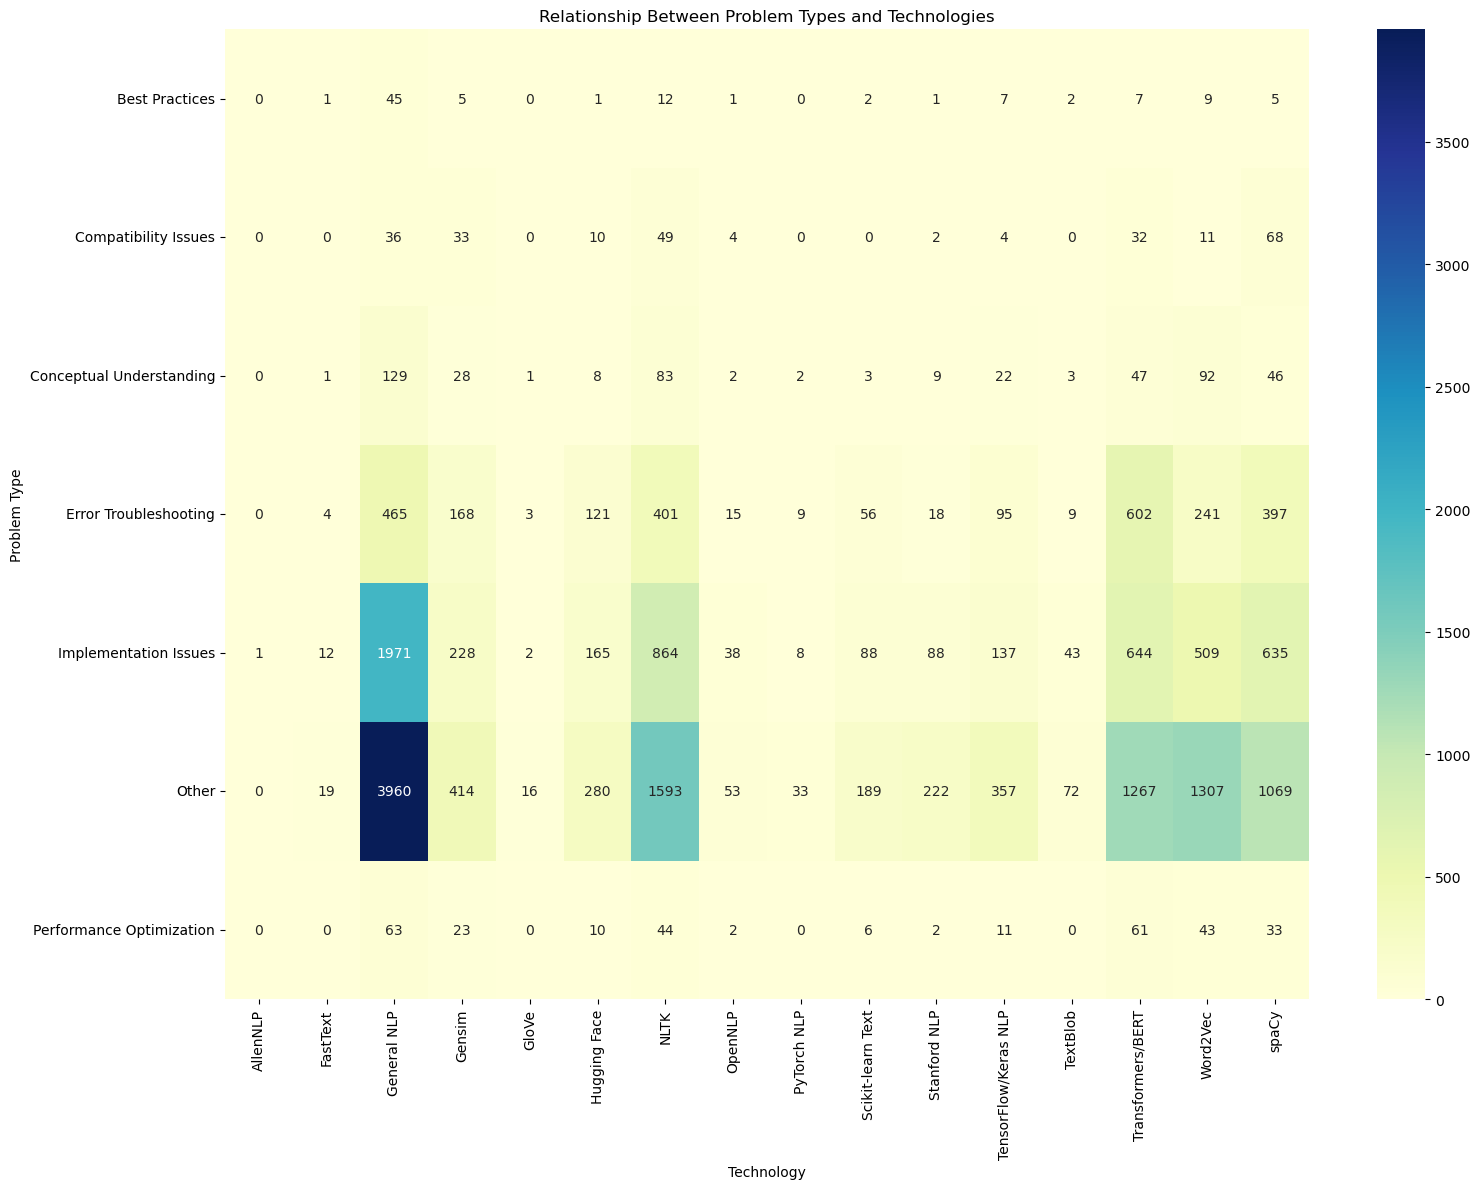

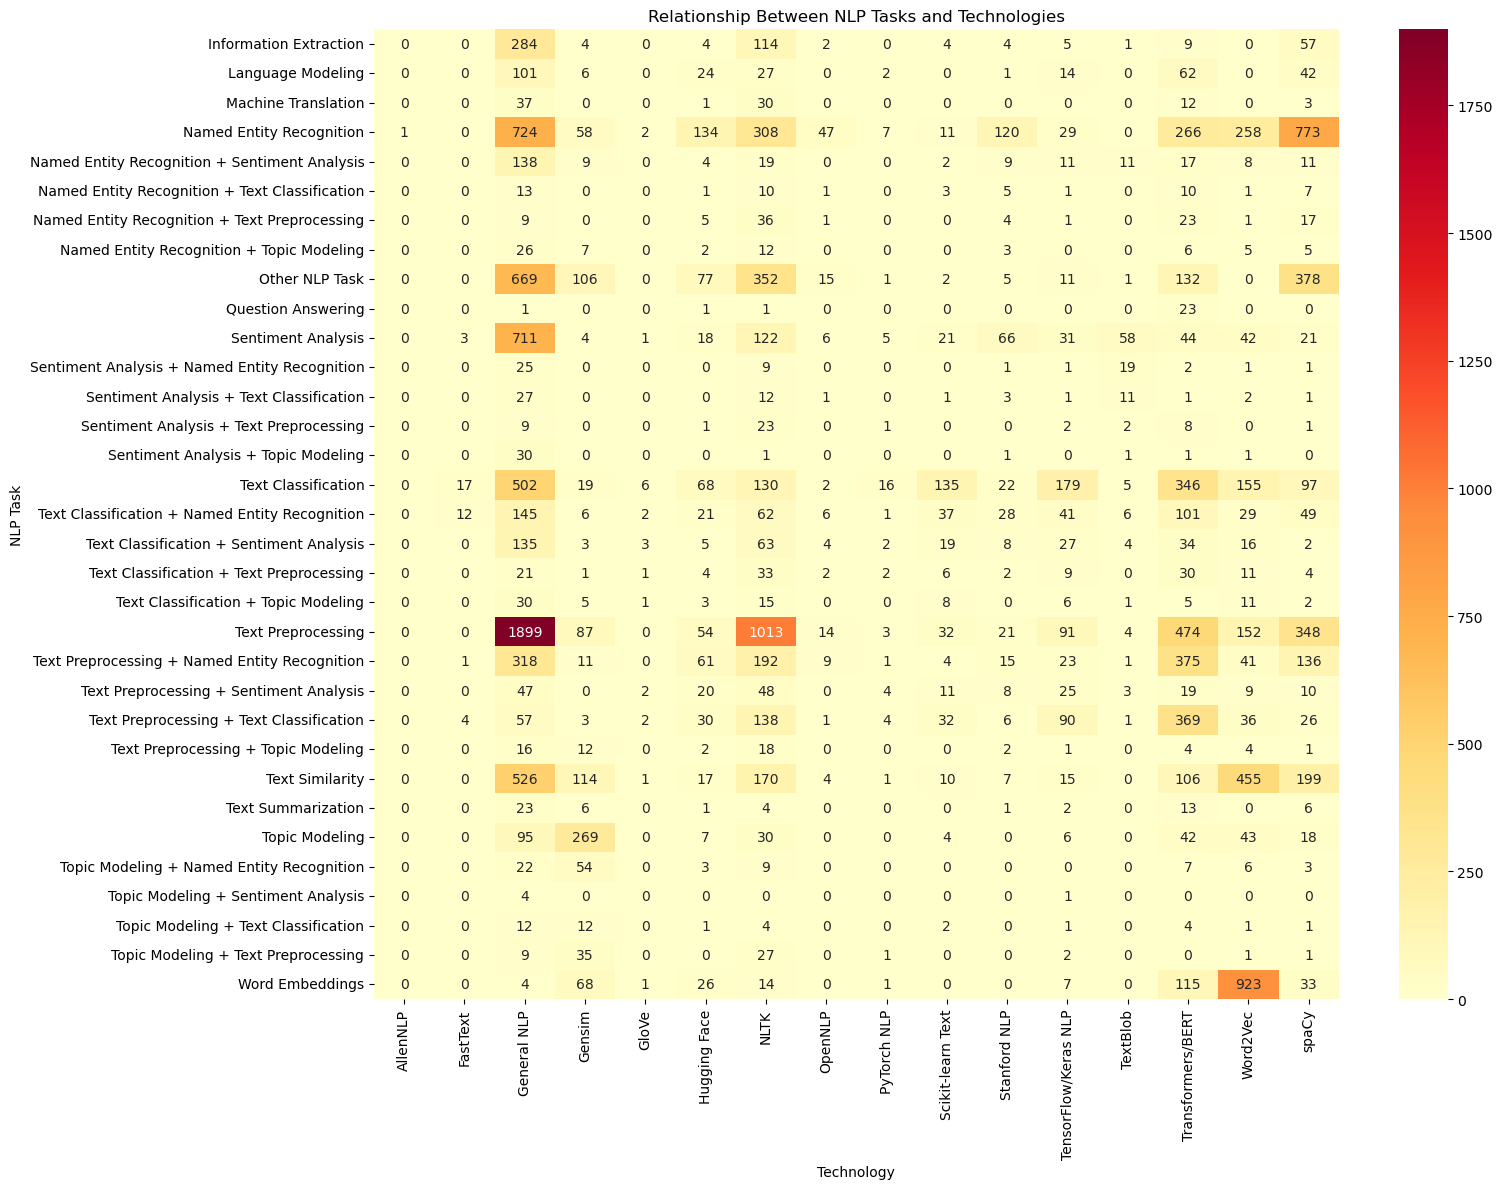

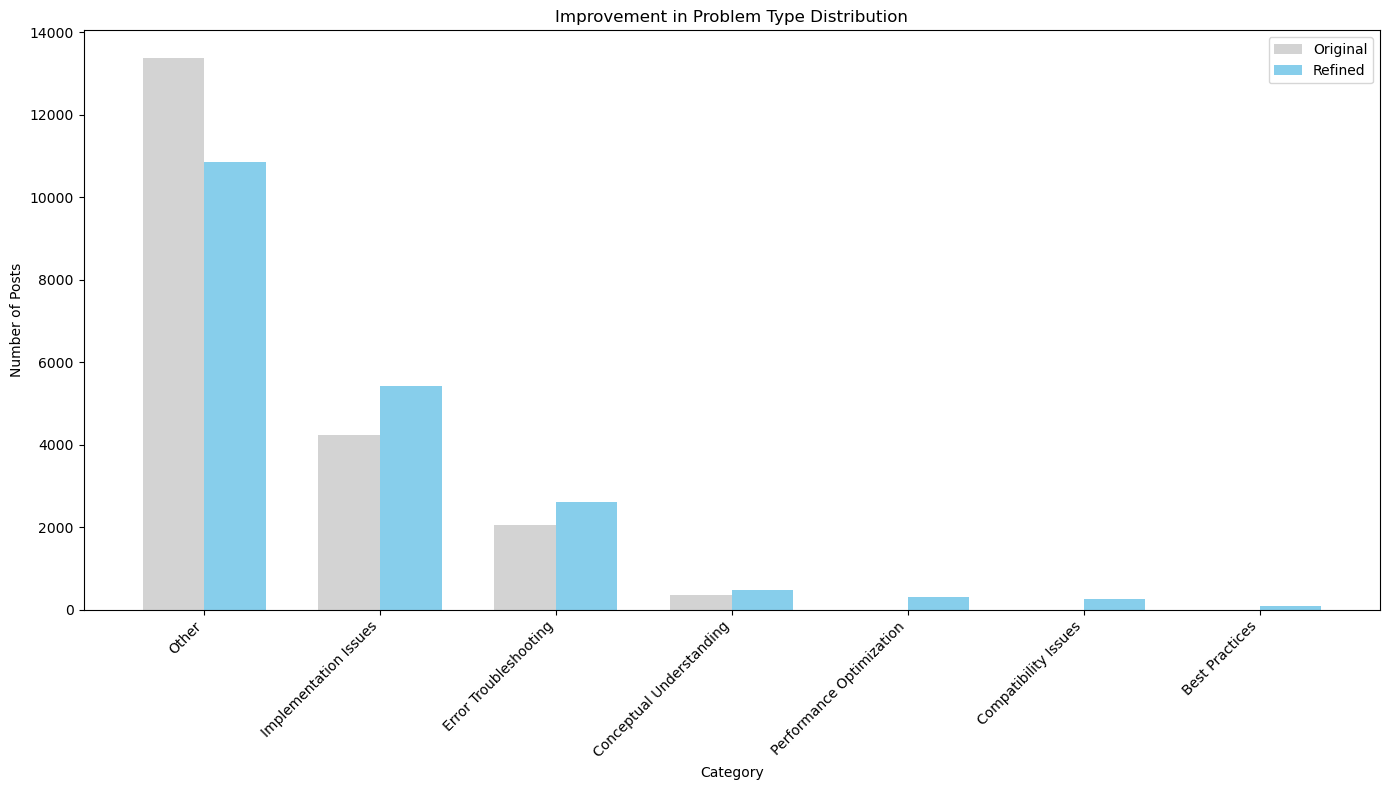

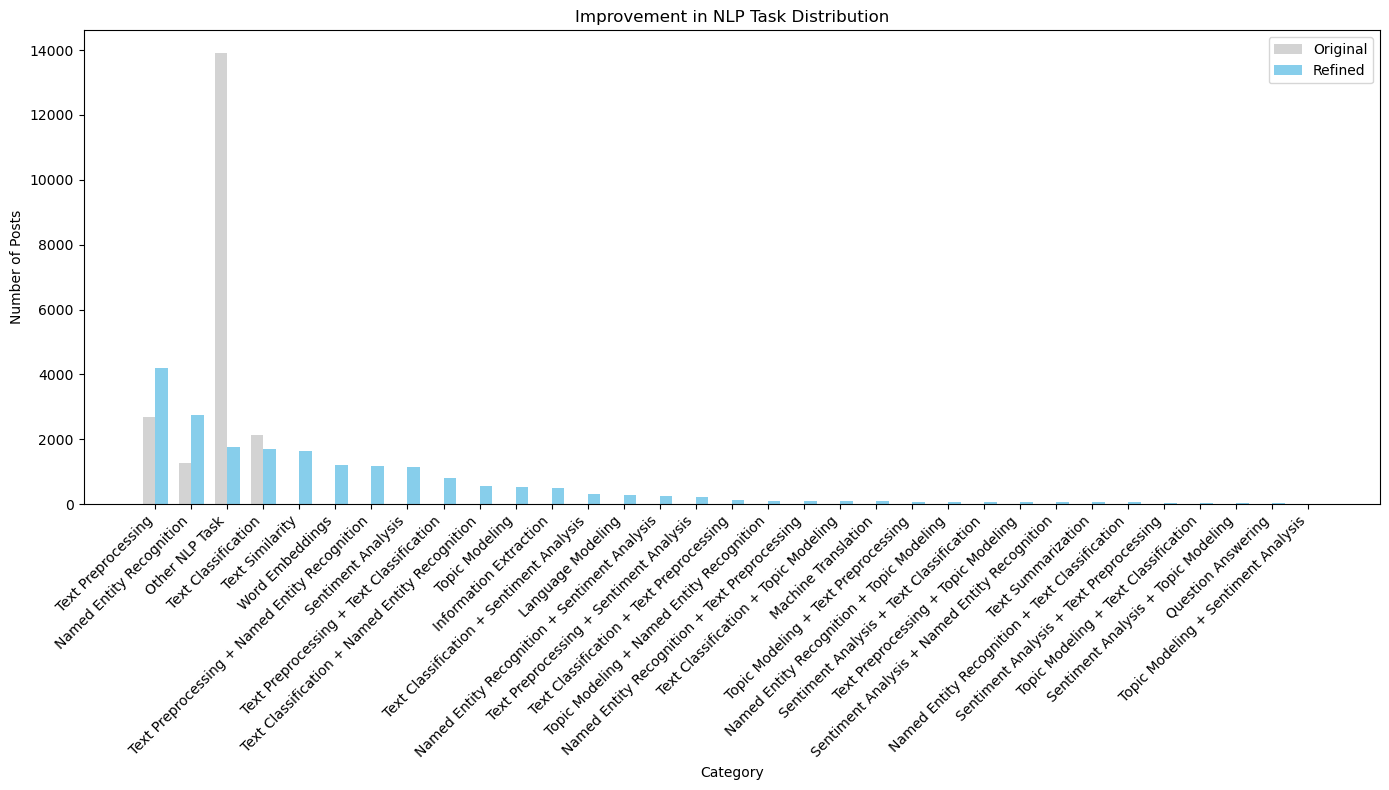

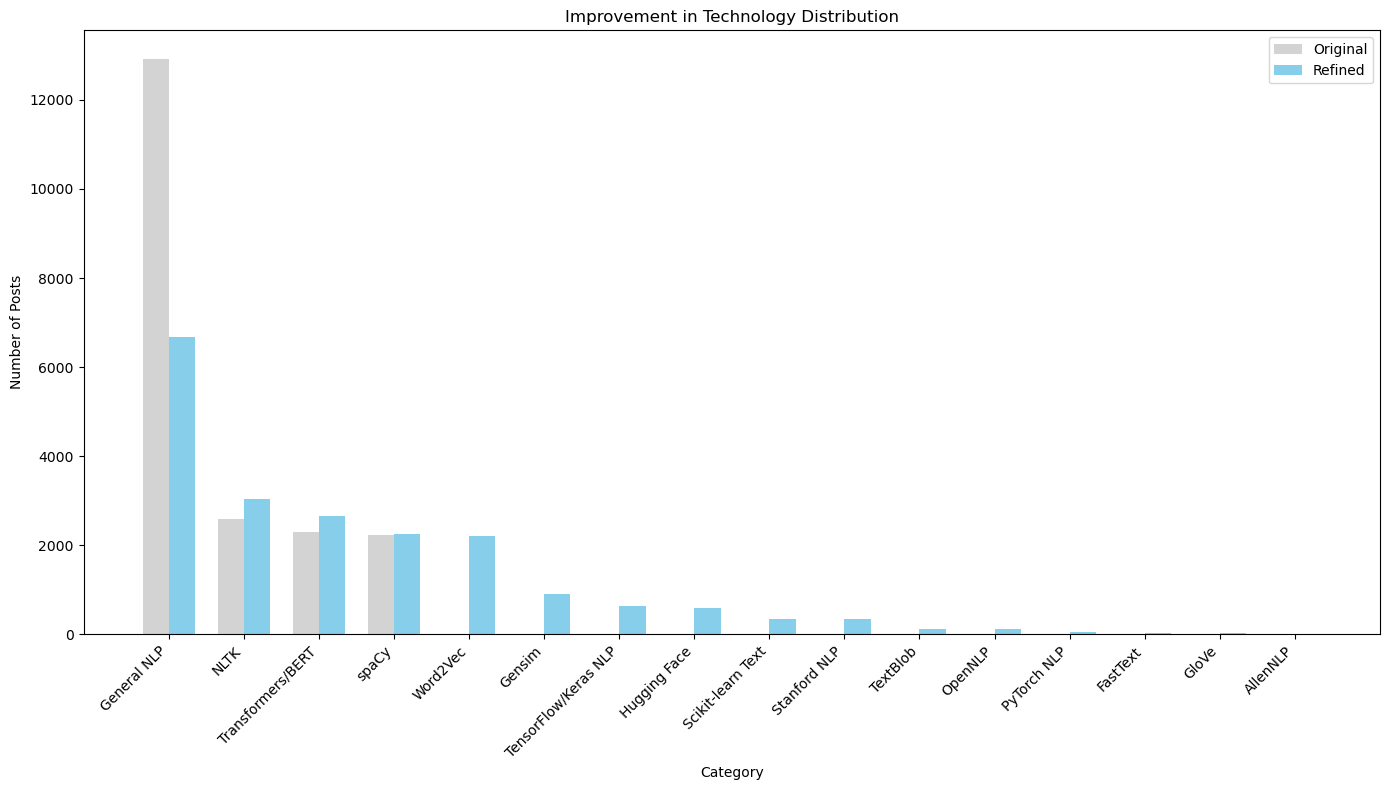

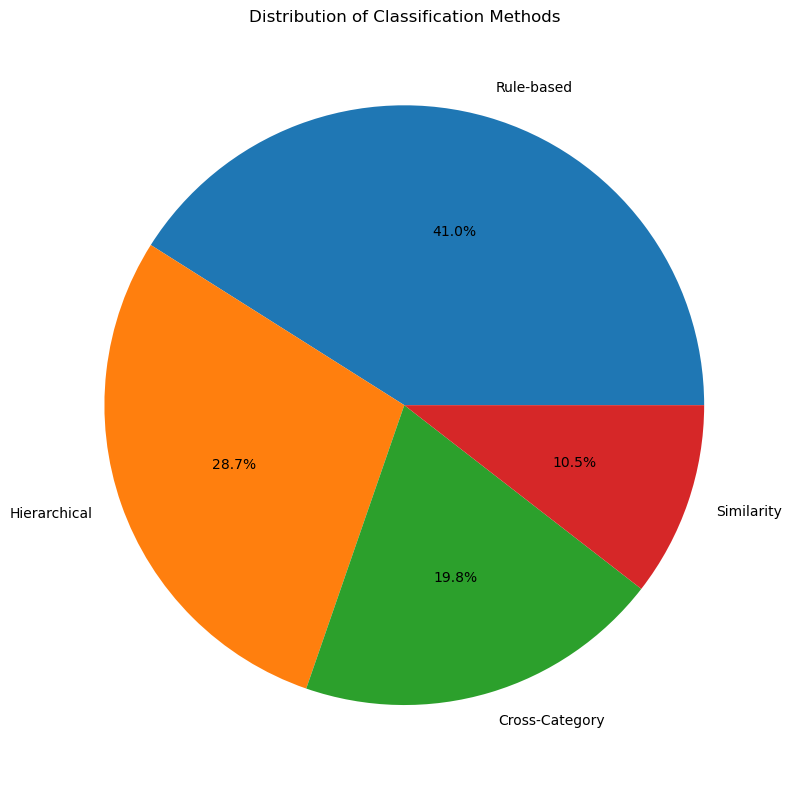

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import random

# Load the categorized dataset
df_ref = pd.read_csv('refined_categorized_nlp_posts.csv')

# Also load the raw dataset that contains the links
df_raw = pd.read_csv('nlp_stackoverflow_raw_posts.csv')

# 1. Sample Validation
def sample_for_validation(df_ref, category_column, n=50):
    """Sample n posts from each category for manual validation"""
    samples = []
    for category in df_ref[category_column].unique():
        category_posts = df_ref[df_ref[category_column] == category]
        if len(category_posts) > n:
            samples.append(category_posts.sample(n))
        else:
            samples.append(category_posts)  # Take all posts if less than n
    
    return pd.concat(samples)

# Sample posts from each problem type, NLP task, and technology category
problem_samples = sample_for_validation(df_ref, 'problem_type')
task_samples = sample_for_validation(df_ref, 'nlp_task')
tech_samples = sample_for_validation(df_ref, 'technology')

# Merge with raw dataset to get the links using 'title' as the common key
problem_samples_with_links = pd.merge(problem_samples, df_raw[['title', 'link']], on='title', how='left')
task_samples_with_links = pd.merge(task_samples, df_raw[['title', 'link']], on='title', how='left')
tech_samples_with_links = pd.merge(tech_samples, df_raw[['title', 'link']], on='title', how='left')

# Export samples for manual validation, now including links
problem_samples_with_links[['title', 'problem_type', 'link']].to_csv('validation_samples_problem_type.csv', index=False)
task_samples_with_links[['title', 'nlp_task', 'link']].to_csv('validation_samples_nlp_task.csv', index=False)
tech_samples_with_links[['title', 'technology', 'link']].to_csv('validation_samples_technology.csv', index=False)


# 2. Confusion Matrix Analysis
# For this, we would need to compare the automated categorization with a ground truth
# Here's a simplified approach using manual validation results
# (In practice, you'd manually validate the samples above and load the results)

# Simulate manual validation for demonstration purposes
def create_simulated_validation(samples, category_column, accuracy=0.85):
    """Create simulated validation results with specified accuracy"""
    samples_copy = samples.copy()
    samples_copy['manual_category'] = samples_copy[category_column]
    
    # For each category, introduce some errors based on desired accuracy
    categories = samples_copy[category_column].unique()
    for category in categories:
        category_mask = samples_copy[category_column] == category
        n_samples = sum(category_mask)
        n_errors = int(n_samples * (1 - accuracy))
        
        if n_errors > 0 and len(categories) > 1:
            # Randomly select samples to modify
            error_indices = np.random.choice(
                samples_copy[category_mask].index, 
                size=n_errors, 
                replace=False
            )
            
            # Assign incorrect categories
            other_categories = [c for c in categories if c != category]
            for idx in error_indices:
                samples_copy.loc[idx, 'manual_category'] = np.random.choice(other_categories)
    
    return samples_copy

# Create simulated validation data
problem_validation = create_simulated_validation(problem_samples, 'problem_type')
task_validation = create_simulated_validation(task_samples, 'nlp_task')
tech_validation = create_simulated_validation(tech_samples, 'technology')

# Create confusion matrices
def plot_confusion_matrix(validation_df, category_column):
    """Create and plot confusion matrix"""
    categories = sorted(validation_df[category_column].unique())
    conf_matrix = confusion_matrix(
        validation_df['manual_category'], 
        validation_df[category_column],
        labels=categories
    )
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=categories,
        yticklabels=categories
    )
    plt.title(f'Confusion Matrix for {category_column}')
    plt.xlabel('Predicted Category')
    plt.ylabel('Actual Category')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{category_column}.png')
#    plt.close()
    
    return conf_matrix

# Create confusion matrices
problem_conf_matrix = plot_confusion_matrix(problem_validation, 'problem_type')
task_conf_matrix = plot_confusion_matrix(task_validation, 'nlp_task')
tech_conf_matrix = plot_confusion_matrix(tech_validation, 'technology')

# 3. Visualizations
# Distribution of posts across categories
plt.figure(figsize=(14, 8))
df_ref['problem_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Problem Types')
plt.xlabel('Problem Type')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('problem_type_distribution.png')
#plt.close()

plt.figure(figsize=(16, 8))
df_ref['nlp_task'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribution of NLP Tasks')
plt.xlabel('NLP Task')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('nlp_task_distribution.png')
#plt.close()

plt.figure(figsize=(14, 8))
df_ref['technology'].value_counts().plot(kind='bar', color='salmon')
plt.title('Distribution of NLP Technologies')
plt.xlabel('Technology')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('technology_distribution.png')
#plt.close()

# Relationships between problem types and technologies
# Create a heatmap
problem_tech_crosstab = pd.crosstab(df_ref['problem_type'], df_ref['technology'])
plt.figure(figsize=(16, 12))
sns.heatmap(problem_tech_crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Relationship Between Problem Types and Technologies')
plt.ylabel('Problem Type')
plt.xlabel('Technology')
plt.tight_layout()
plt.savefig('problem_tech_heatmap.png')
#plt.close()

# Relationships between NLP tasks and technologies
task_tech_crosstab = pd.crosstab(df_ref['nlp_task'], df_ref['technology'])
plt.figure(figsize=(16, 12))
sns.heatmap(task_tech_crosstab, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Relationship Between NLP Tasks and Technologies')
plt.ylabel('NLP Task')
plt.xlabel('Technology')
plt.tight_layout()
plt.savefig('task_tech_heatmap.png')
#plt.close()

# Change in "Other" category size before and after refinement
# For this, you need the original categorization results

# Simulate original categorization data
original_categories = {
    'problem_type': {
        'Other': 13377,
        'Implementation Issues': 4244,
        'Error Troubleshooting': 2044,
        'Conceptual Understanding': 344
    },
    'nlp_task': {
        'Other NLP Task': 13913,
        'Text Preprocessing': 2683,
        'Text Classification': 2132,
        'Named Entity Recognition': 1281
    },
    'technology': {
        'General NLP': 12915,
        'NLTK': 2585,
        'Transformers/BERT': 2290,
        'spaCy': 2219
    }
}

# Create a comparison chart for each category type
def plot_category_improvement(original_counts, new_counts, category_type):
    """Plot before and after counts for categories"""
    # Get all categories
    all_categories = sorted(set(list(original_counts.keys()) + list(new_counts.keys())))
    
    # Create dataframe for plotting
    compare_df = pd.DataFrame({
        'Category': all_categories,
        'Original': [original_counts.get(cat, 0) for cat in all_categories],
        'Refined': [new_counts.get(cat, 0) for cat in all_categories]
    })
    
    # Sort by refined counts
    compare_df = compare_df.sort_values('Refined', ascending=False)
    
    # Plot
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    x = np.arange(len(compare_df))
    
    plt.bar(x - bar_width/2, compare_df['Original'], bar_width, label='Original', color='lightgray')
    plt.bar(x + bar_width/2, compare_df['Refined'], bar_width, label='Refined', color='skyblue')
    
    plt.title(f'Improvement in {category_type} Distribution')
    plt.xlabel('Category')
    plt.ylabel('Number of Posts')
    plt.xticks(x, compare_df['Category'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{category_type.lower().replace(" ", "_")}_improvement.png')
#    plt.close()
    
    # Calculate reduction in "Other" category percentage
    if 'Other' in original_counts or 'Other NLP Task' in original_counts or 'General NLP' in original_counts:
        other_key = 'Other' if 'Other' in original_counts else 'Other NLP Task' if 'Other NLP Task' in original_counts else 'General NLP'
        original_other_percent = original_counts[other_key] / sum(original_counts.values()) * 100
        new_other_percent = new_counts.get(other_key, 0) / sum(new_counts.values()) * 100
        reduction = original_other_percent - new_other_percent
        
        print(f"{category_type} - 'Other' category reduction: {reduction:.2f}% (from {original_other_percent:.2f}% to {new_other_percent:.2f}%)")

# Get current counts
current_problem_counts = df_ref['problem_type'].value_counts().to_dict()
current_task_counts = df_ref['nlp_task'].value_counts().to_dict()
current_tech_counts = df_ref['technology'].value_counts().to_dict()

# Plot improvements
plot_category_improvement(original_categories['problem_type'], current_problem_counts, 'Problem Type')
plot_category_improvement(original_categories['nlp_task'], current_task_counts, 'NLP Task')
plot_category_improvement(original_categories['technology'], current_tech_counts, 'Technology')

# Additionally, create a pie chart showing classification methods
plt.figure(figsize=(10, 8))
df_ref['classification_method'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Classification Methods')
plt.ylabel('')
plt.tight_layout()
plt.savefig('classification_methods_pie.png')
#plt.close()

print("Validation and analysis completed. All visualizations saved.")